In [1]:
import pandas as pd
from pandas import ExcelFile
from pandas.io.json import json_normalize 
import json

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import string
import numpy as np
import seaborn as sns
import spacy
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

import os
%matplotlib inline

In [2]:

drugs_model = pd.read_csv('drugs_model2.csv')

In [3]:
drugs_model.head()

Unnamed: 0  UniqueID                  drugName  \
0           0    206461                 Valsartan   
1           1     95260                Guanfacine   
2           2     92703                    Lybrel   
3           3    138000                Ortho Evra   
4           4     35696  Buprenorphine / naloxone   

                      condition  \
0  Left Ventricular Dysfunction   
1                          ADHD   
2                 Birth Control   
3                 Birth Control   
4             Opiate Dependence   

                                              review  rating        date  \
0  "It has no side effect, I take it in combinati...     9.0  2012-05-20   
1  "My son is halfway through his fourth week of ...     8.0  2010-04-27   
2  "I used to take another oral contraceptive, wh...     5.0  2009-12-14   
3  "This is my first time using any form of birth...     8.0  2015-11-03   
4  "Suboxone has completely turned my life around...     9.0  2016-11-27   

   usefulCount  review_length  word_count  \
0           27             79          17   
1          192            741         141   
2           17            755         133   
3           10            448          89   
4           37            719         134   

                                          clean_text rating_class  \
0  it has no side effect i take it in combination...     positive   
1  my son is halfway through his fourth week of i...     positive   
2  i used to take another oral contraceptive whic...      neutral   
3  this is my first time using any form of birth ...     positive   
4  suboxone has completely turned my life around ...     positive   

   rating_class_numeric  
0                     2  
1                     2  
2                     1  
3                     2  
4                     2

In [4]:
#drugs_model.date = pd.to_datetime(drugs_model['date'])


In [5]:
drugs_model.shape

(215063, 13)

In [6]:
drugs_model.isnull().sum()

Unnamed: 0                 0
UniqueID                   0
drugName                   0
condition               1194
review                     0
rating                     0
date                       0
usefulCount                0
review_length              0
word_count                 0
clean_text                 4
rating_class               0
rating_class_numeric       0
dtype: int64

In [7]:
drugs_model.condition.value_counts()

Birth Control                                              38436
Depression                                                 12164
Pain                                                        8245
Anxiety                                                     7812
Acne                                                        7435
Bipolar Disorde                                             5604
Insomnia                                                    4904
Weight Loss                                                 4857
Obesity                                                     4757
ADHD                                                        4509
Diabetes, Type 2                                            3362
Emergency Contraception                                     3290
High Blood Pressure                                         3104
Vaginal Yeast Infection                                     3085
Abnormal Uterine Bleeding                                   2744
Bowel Preparation        

In [8]:
Obesity = drugs_model[drugs_model['condition'] == 'Obesity']
weight_loss = drugs_model[drugs_model['condition'] == 'Weight Loss']
diabetes = drugs_model[drugs_model['condition'] == 'Diabetes, Type 2']
smoking_cessation = drugs_model[drugs_model['condition'] == 'Smoking Cessation']



In [9]:
weight_loss.isnull().sum()

Unnamed: 0              0
UniqueID                0
drugName                0
condition               0
review                  0
rating                  0
date                    0
usefulCount             0
review_length           0
word_count              0
clean_text              0
rating_class            0
rating_class_numeric    0
dtype: int64

In [10]:
print(Obesity.info())
print(diabetes.info())
print(weight_loss.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4757 entries, 15 to 215051
Data columns (total 13 columns):
Unnamed: 0              4757 non-null int64
UniqueID                4757 non-null int64
drugName                4757 non-null object
condition               4757 non-null object
review                  4757 non-null object
rating                  4757 non-null float64
date                    4757 non-null object
usefulCount             4757 non-null int64
review_length           4757 non-null int64
word_count              4757 non-null int64
clean_text              4757 non-null object
rating_class            4757 non-null object
rating_class_numeric    4757 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 520.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3362 entries, 50 to 214969
Data columns (total 13 columns):
Unnamed: 0              3362 non-null int64
UniqueID                3362 non-null int64
drugName                3362 non-null objec

In [11]:
weight_loss.rating.value_counts()

10.0    2195
9.0      901
8.0      524
1.0      360
7.0      250
5.0      173
6.0      148
3.0      110
2.0      110
4.0       86
Name: rating, dtype: int64

In [12]:
smoking_cessation.rating_class.value_counts()

positive    2145
negative     192
neutral      103
Name: rating_class, dtype: int64

In [13]:
diabetes.rating.value_counts()

10.0    970
1.0     505
9.0     505
8.0     393
7.0     210
5.0     201
6.0     163
2.0     162
3.0     152
4.0     101
Name: rating, dtype: int64

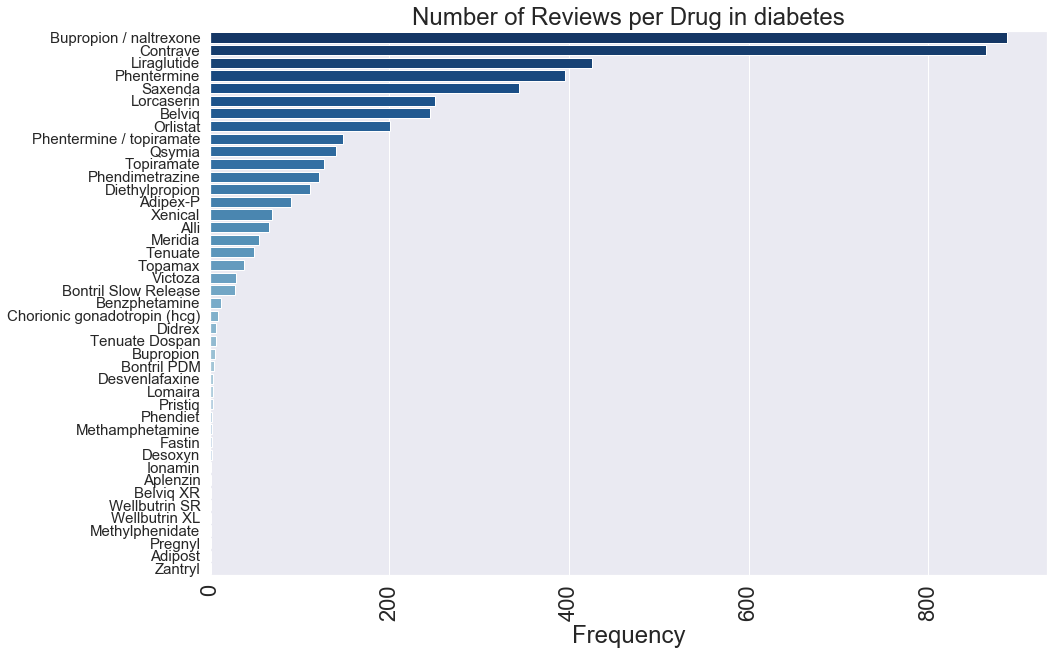

In [14]:
drug = Obesity.drugName.value_counts().reset_index().rename(columns={'index': 'Drug', 'drugName': 'Frequency'})
sns.set(rc={'figure.figsize':(15,10)}, font_scale=2)
sns.set_style("darkgrid")
sns.barplot(y="Drug", x="Frequency", data=drug.iloc[0:50], palette= 'Blues_r')
plt.title('Number of Reviews per Drug in diabetes')
plt.ylabel('', fontsize=20)
plt.xlabel('Frequency')
plt.xticks(rotation = 90)
plt.yticks(fontsize = 15);

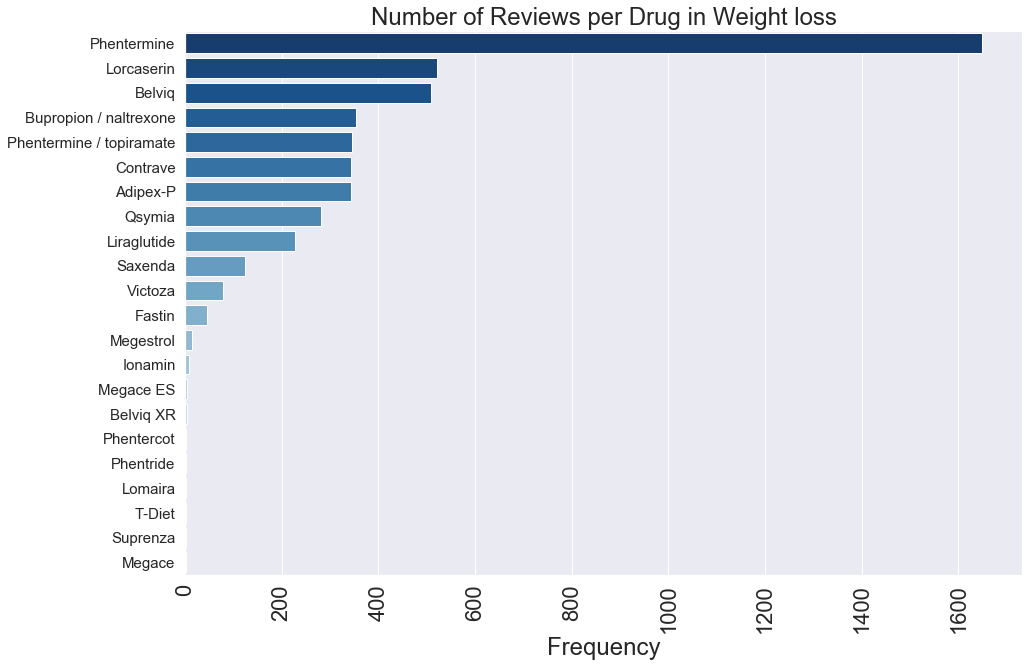

In [15]:
drug = weight_loss.drugName.value_counts().reset_index().rename(columns={'index': 'Drug', 'drugName': 'Frequency'})
sns.set(rc={'figure.figsize':(15,10)}, font_scale=2)
sns.set_style("darkgrid")
sns.barplot(y="Drug", x="Frequency", data=drug.iloc[0:50], palette= 'Blues_r')
plt.title('Number of Reviews per Drug in Weight loss')
plt.ylabel('', fontsize=20)
plt.xlabel('Frequency')
plt.xticks(rotation = 90)
plt.yticks(fontsize = 15);

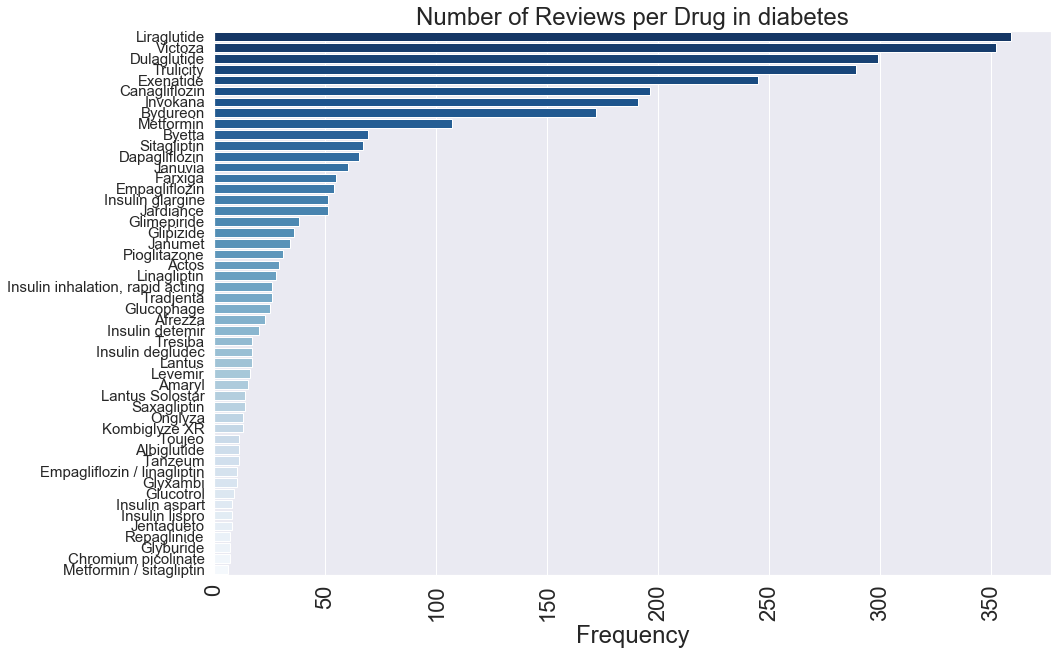

In [16]:
drug = diabetes.drugName.value_counts().reset_index().rename(columns={'index': 'Drug', 'drugName': 'Frequency'})
sns.set(rc={'figure.figsize':(15,10)}, font_scale=2)
sns.set_style("darkgrid")
sns.barplot(y="Drug", x="Frequency", data=drug.iloc[0:50], palette= 'Blues_r')
plt.title('Number of Reviews per Drug in diabetes')
plt.ylabel('', fontsize=20)
plt.xlabel('Frequency')
plt.xticks(rotation = 90)
plt.yticks(fontsize = 15);

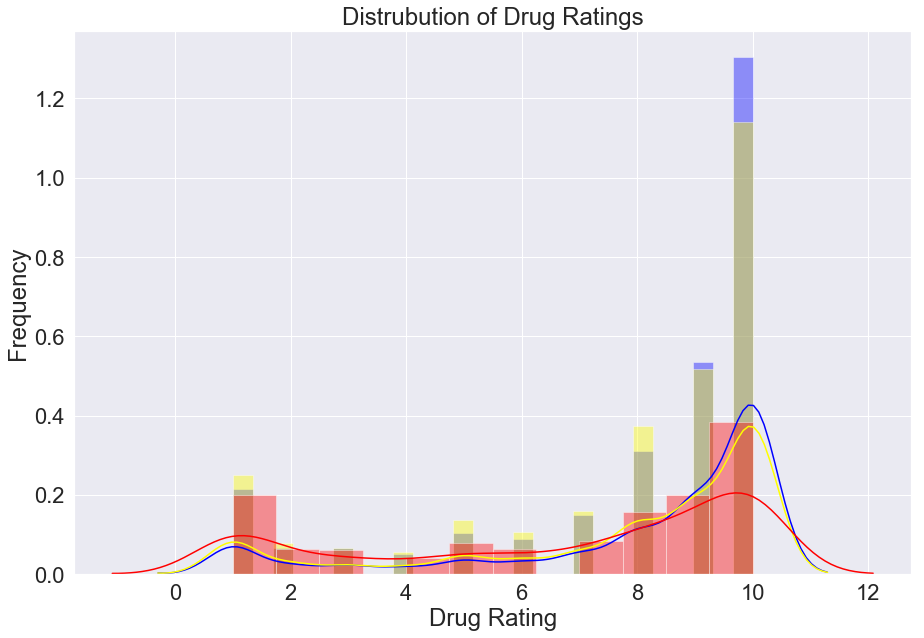

In [17]:
sns.distplot(weight_loss.rating, color = 'Blue')
#drugs_combined.rating.hist()
plt.title('Distrubution of Drug Ratings')
plt.xlabel('Drug Rating')
plt.ylabel('Frequency')


sns.distplot(Obesity.rating, color = 'yellow')
#drugs_combined.rating.hist()
plt.title('Distrubution of Drug Ratings')
plt.xlabel('Drug Rating')
plt.ylabel('Frequency');

sns.distplot(diabetes.rating, color = 'red')
#drugs_combined.rating.hist()
plt.title('Distrubution of Drug Ratings')
plt.xlabel('Drug Rating')
plt.ylabel('Frequency');



In [18]:
#drugs = fullmerge.groupby(['drugName'], as_index=False)['rating'].mean().round(decimals = 2)

In [19]:
# drugs_combined["is_duplicate"]= drugs_combined.duplicated()
 


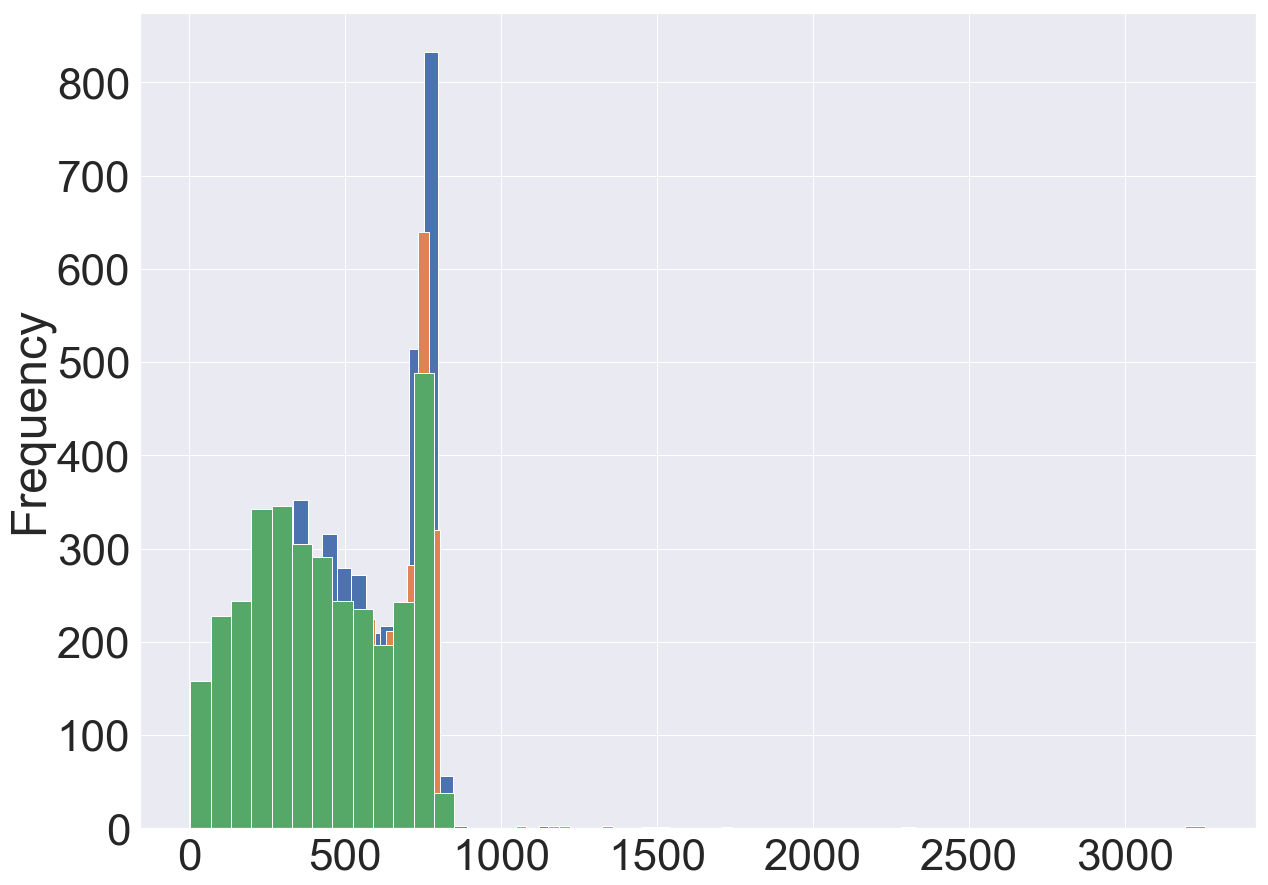

In [20]:
sns.set(style="darkgrid", rc={'figure.figsize':(20,15)},color_codes=True,font_scale=4)
weight_loss['review_length'].plot(bins=50, kind='hist'); 

sns.set(style="darkgrid", rc={'figure.figsize':(20,15)},color_codes=True,font_scale=4)
Obesity['review_length'].plot(bins=50, kind='hist'); 

sns.set(style="darkgrid", rc={'figure.figsize':(20,15)},color_codes=True,font_scale=4)
diabetes['review_length'].plot(bins=50, kind='hist'); 


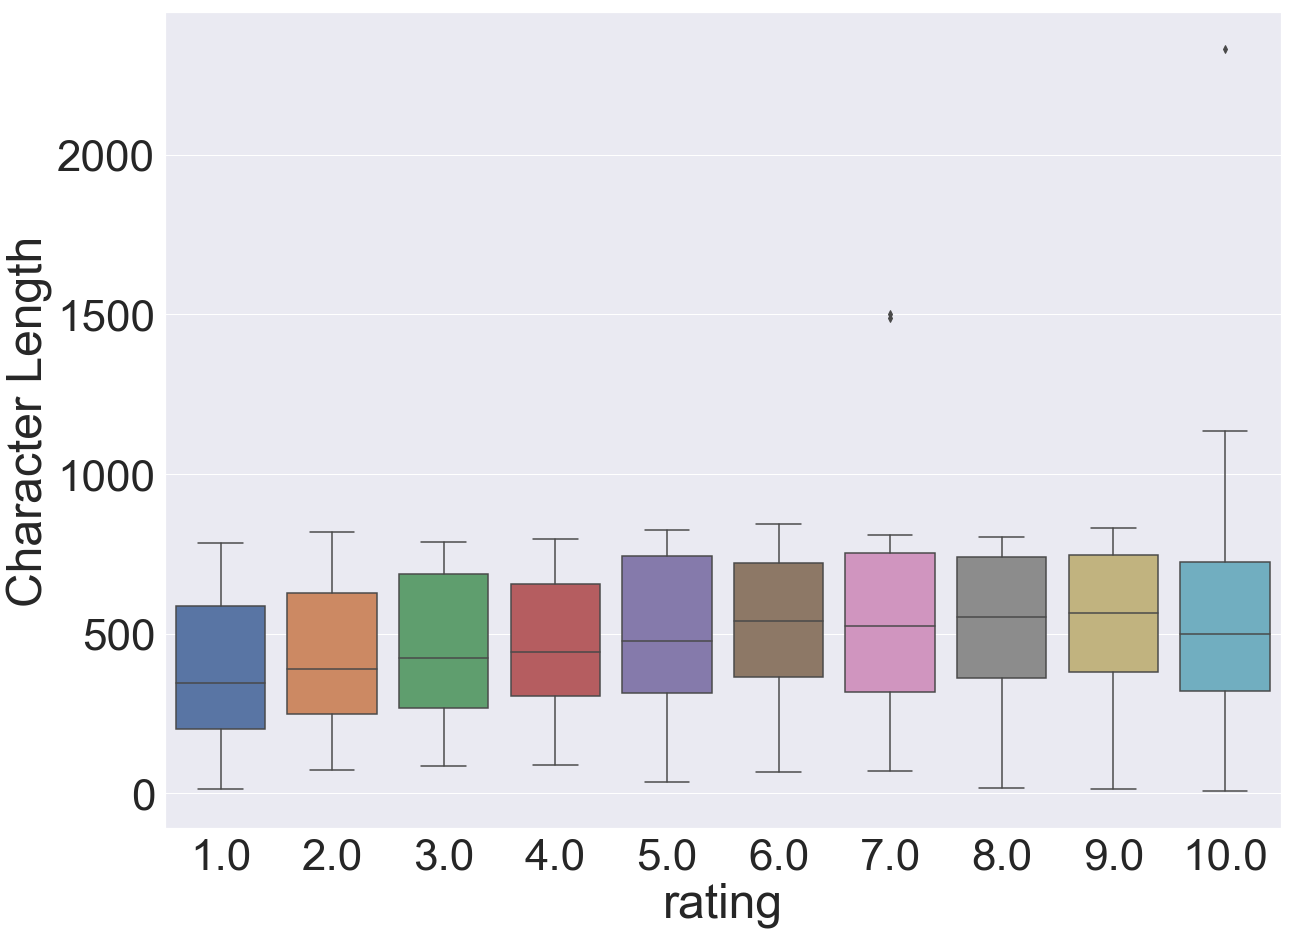

In [21]:
sns.set(style="darkgrid", rc={'figure.figsize':(20,15)},color_codes=True,font_scale=4)
sns.boxplot(x='rating', y='review_length', data=weight_loss)
plt.ylabel('Character Length');


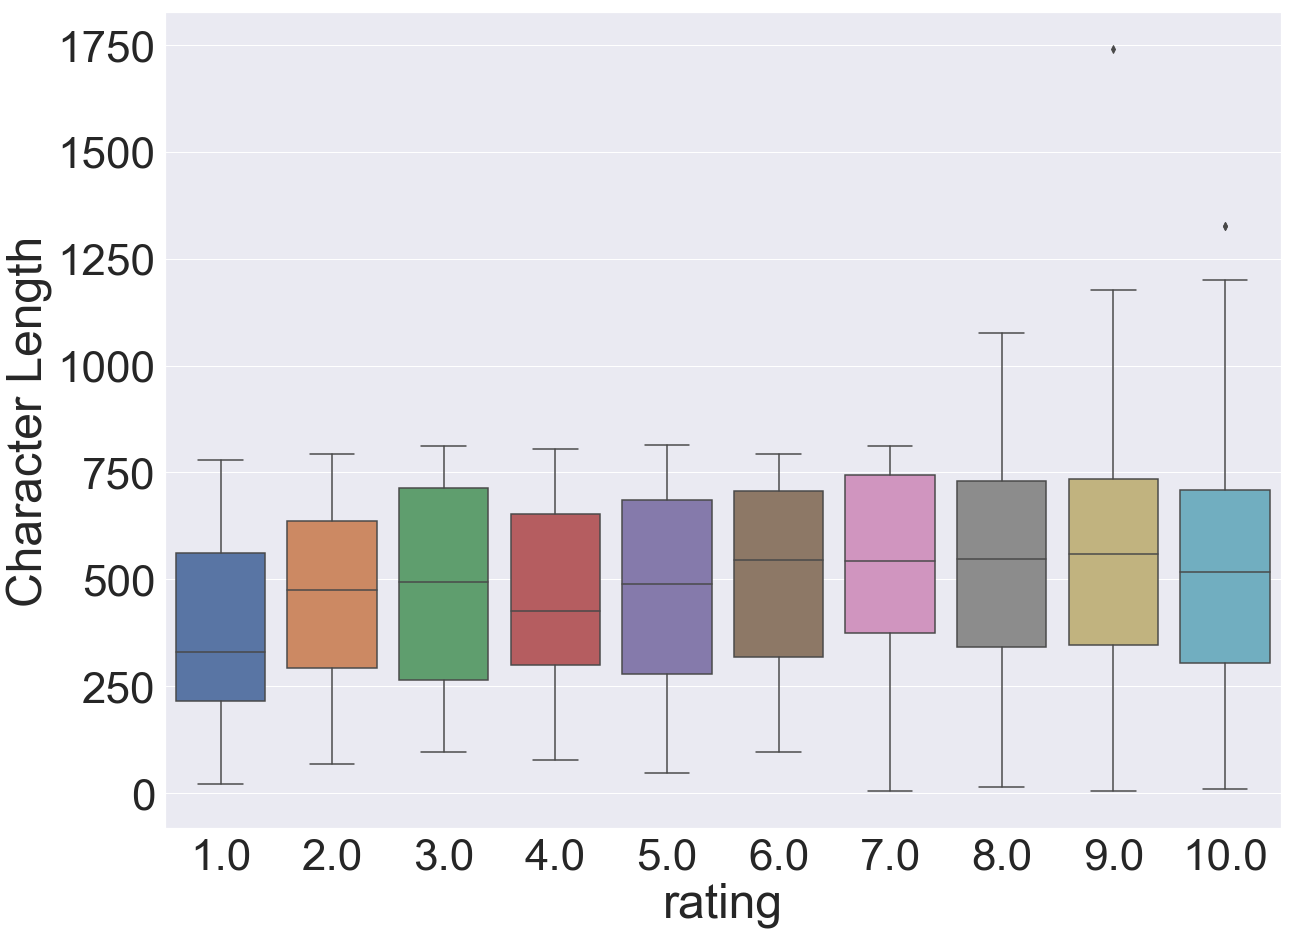

In [22]:

sns.set(style="darkgrid", rc={'figure.figsize':(20,15)},color_codes=True,font_scale=4)
sns.boxplot(x='rating', y='review_length', data=Obesity)
plt.ylabel('Character Length');



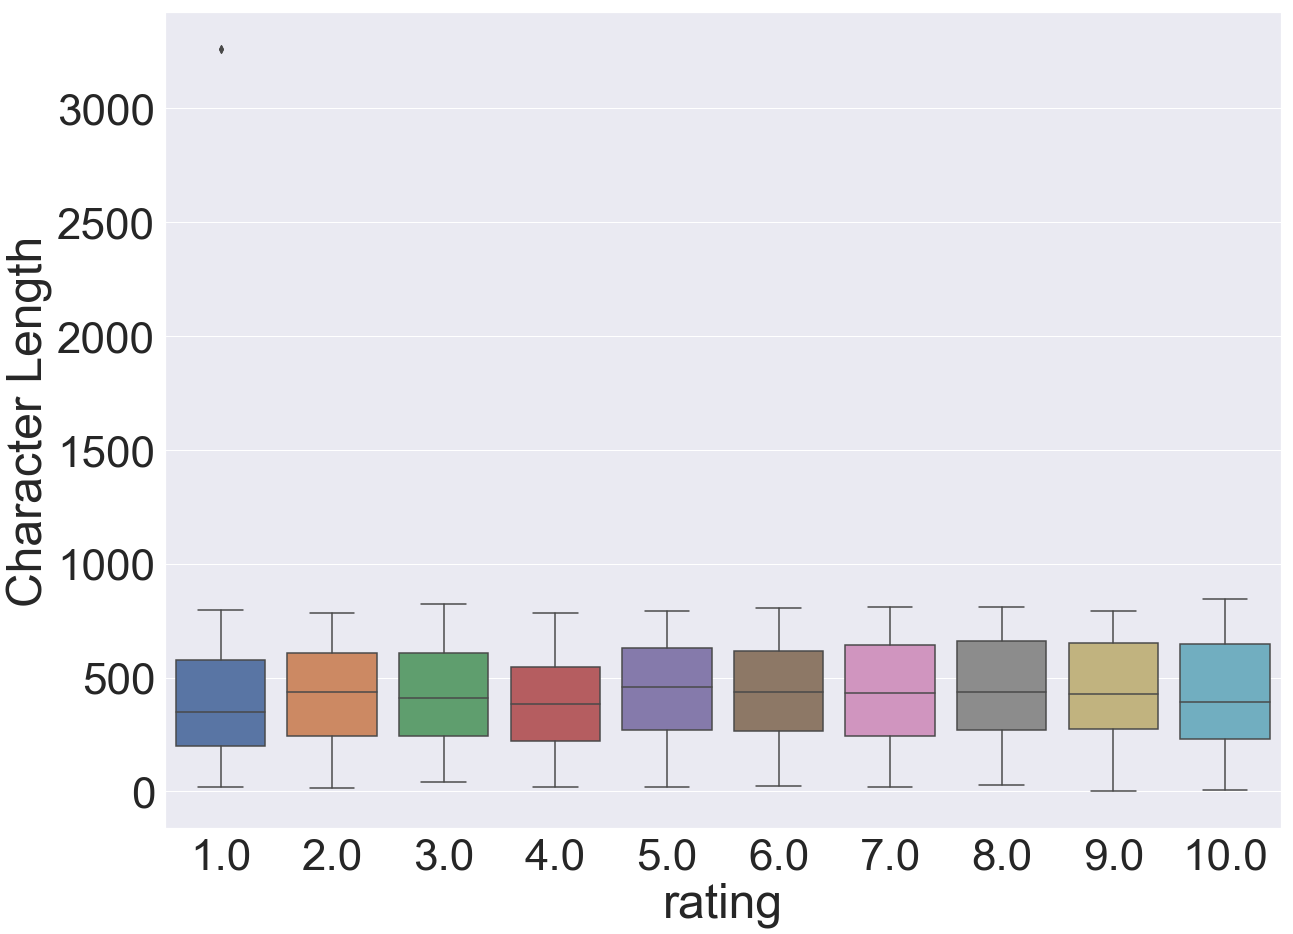

In [23]:
sns.set(style="darkgrid", rc={'figure.figsize':(20,15)},color_codes=True,font_scale=4)
sns.boxplot(x='rating', y='review_length', data=diabetes)
plt.ylabel('Character Length');

Text(0,0.5,'Word count')

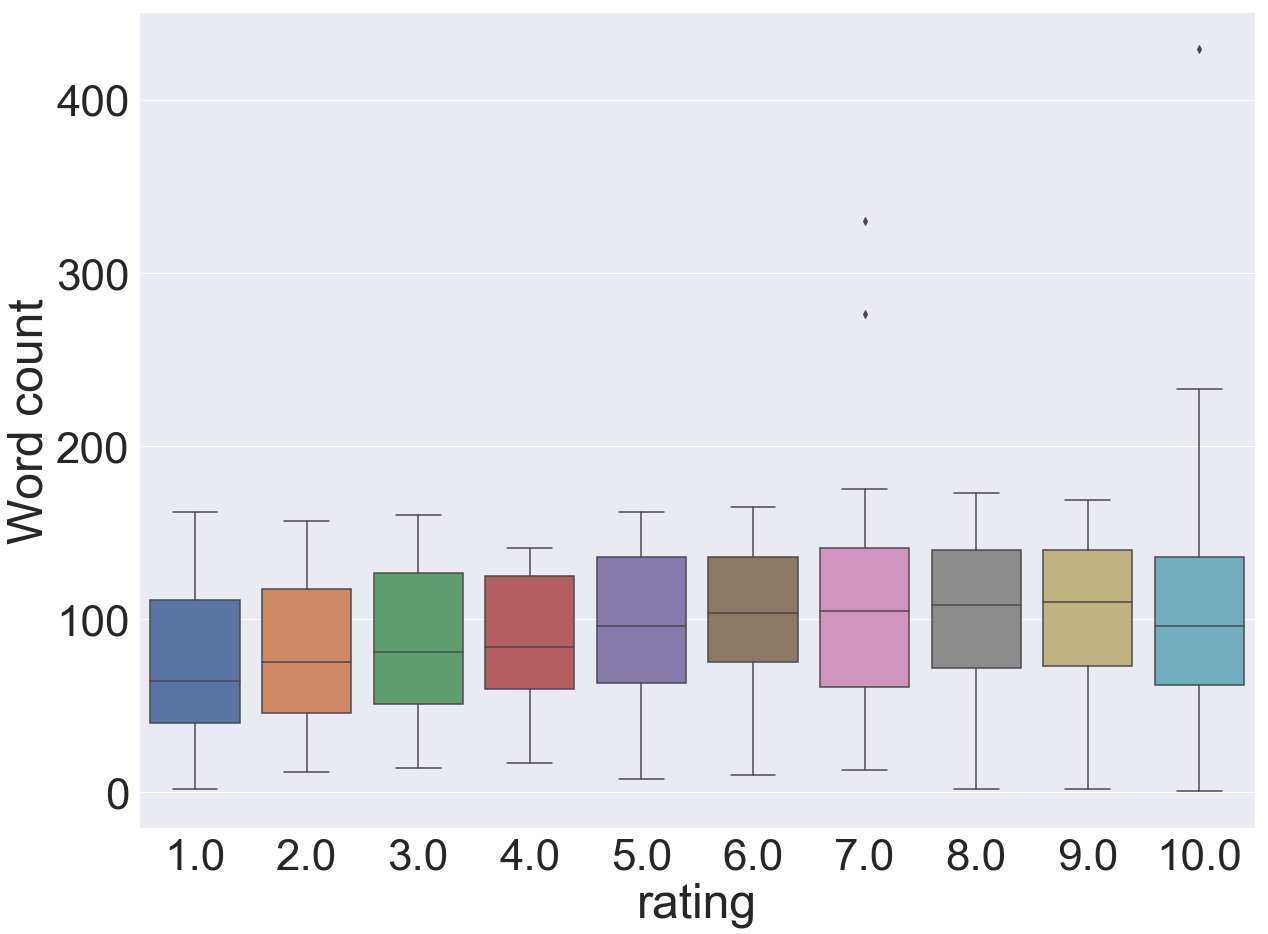

In [24]:
sns.set(style="darkgrid", rc={'figure.figsize':(20,15)},color_codes=True,font_scale=4)
sns.boxplot(x='rating', y='word_count', data=weight_loss)
plt.ylabel('Word count')

Text(0,0.5,'Word count')

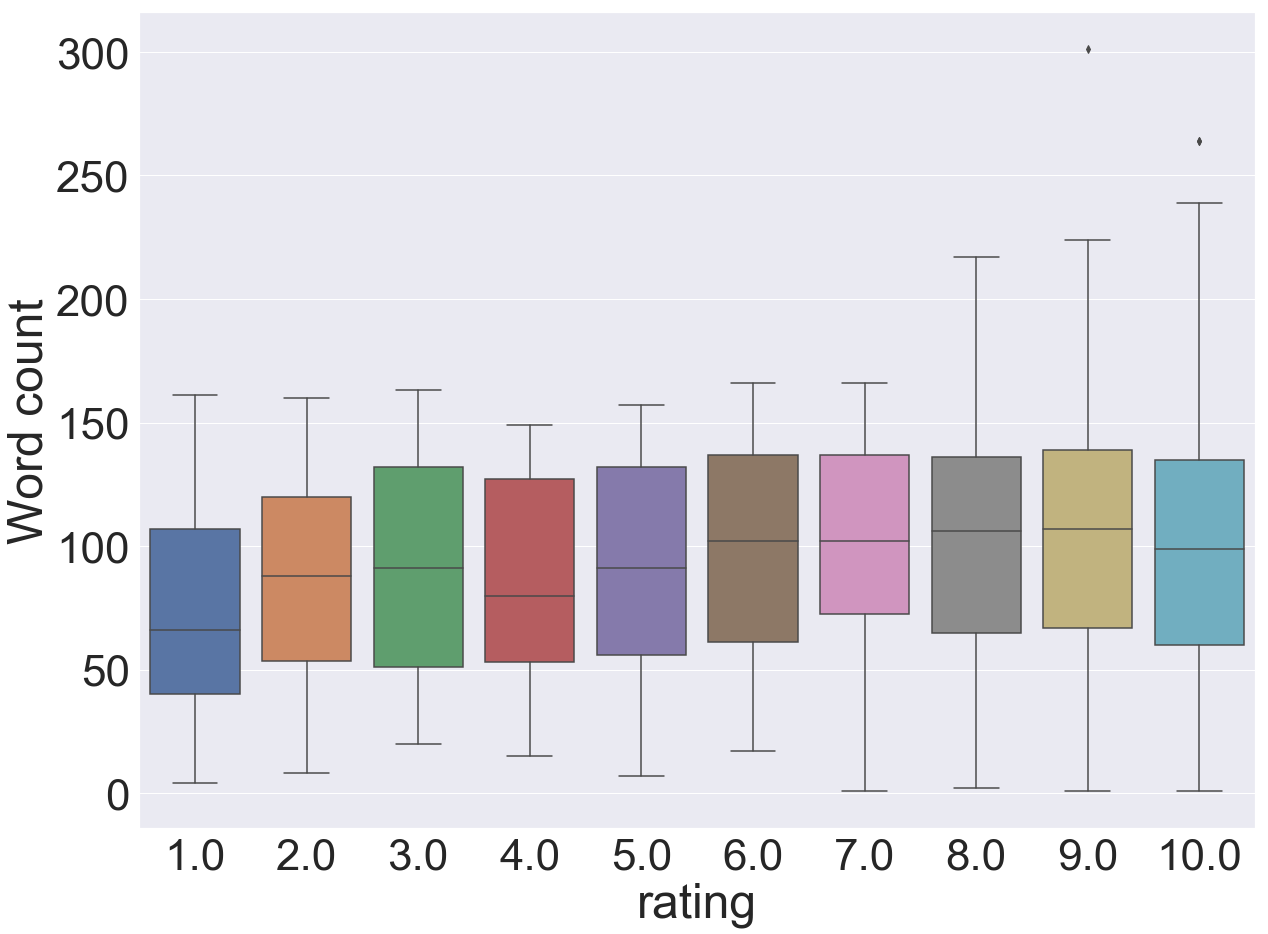

In [25]:
sns.set(style="darkgrid", rc={'figure.figsize':(20,15)},color_codes=True,font_scale=4)
sns.boxplot(x='rating', y='word_count', data=Obesity)
plt.ylabel('Word count')

Text(0,0.5,'Word count')

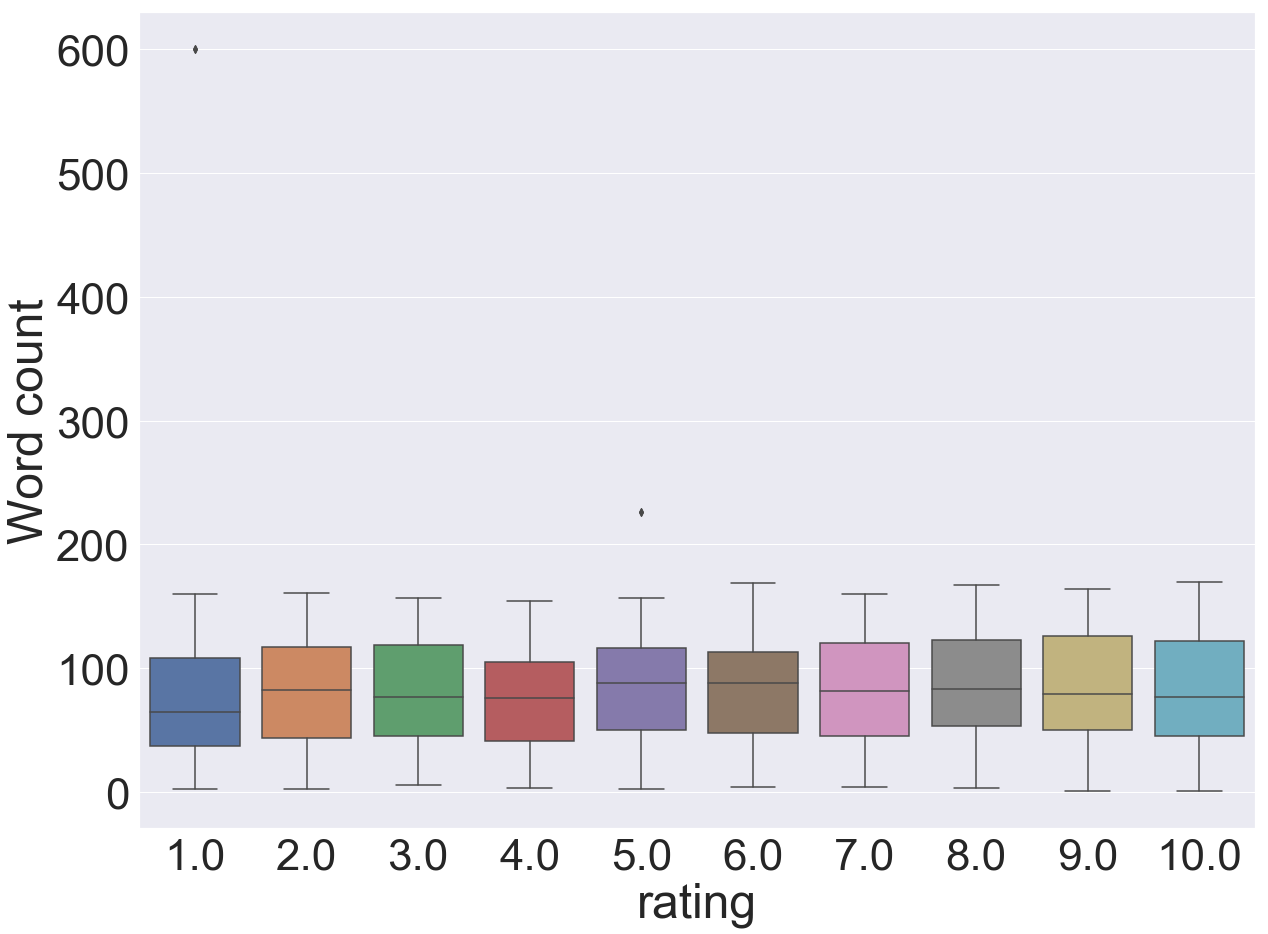

In [26]:
sns.set(style="darkgrid", rc={'figure.figsize':(20,15)},color_codes=True,font_scale=4)
sns.boxplot(x='rating', y='word_count', data=diabetes)
plt.ylabel('Word count')

In [27]:
weight_loss.head()

Unnamed: 0  UniqueID                  drugName    condition  \
178         178    164952  Phentermine / topiramate  Weight Loss   
254         254    145900                    Qsymia  Weight Loss   
280         280     52117                  Adipex-P  Weight Loss   
380         380    145785                    Qsymia  Weight Loss   
408         408    145840                    Qsymia  Weight Loss   

                                                review  rating        date  \
178  "I have been on the Qysmia for 3 weeks now.  I...     8.0  2015-12-25   
254  "My Dr agreed to over see putting me on Qsymia...     9.0  2013-02-24   
280  "I just started Adipex-P 37.5mg on March 6th, ...     8.0  2011-03-10   
380  "Began taking Qsymia 3.75 in June 2013. Its on...    10.0  2014-05-26   
408  "Made me jittery and could not sleep. Lost wei...     1.0  2013-08-21   

     usefulCount  review_length  word_count  \
178           38            741         173   
254           46            472          95   
280            7            742         151   
380           61            481          90   
408           59            190          33   

                                            clean_text rating_class  \
178  i have been on the qysmia for weeks now i want...     positive   
254  my dr agreed to over see putting me on qsymia ...     positive   
280  i just started adipex p mg on march th i am in...     positive   
380  began taking qsymia in june its one year later...     positive   
408  made me jittery and could not sleep lost weigh...     negative   

     rating_class_numeric  
178                     2  
254                     2  
280                     2  
380                     2  
408                     0

In [28]:
weight_loss_postive = weight_loss.loc[(weight_loss['rating_class_numeric'])==2]

In [29]:
# stop = set(stopwords.words("english"))
# stop.update(("mg","day", 'month', 'first','time', 'took','week', 'year', 'phentermine', 'adipex', 'belviq', 'contrave'))

            Bi-gram  Freq
0      side effects  1314
1          lost lbs   981
2         have lost   883
3         have been   880
4          and have   841
5         dry mouth   838
6            in the   837
7         the first   834
8       lost pounds   733
9       weight loss   644
10          been on   634
11   started taking   578
12           to eat   569
13          to lose   564
14           for me   562
15           so far   552
16        my doctor   533
17           on the   512
18           of the   477
19           to the   469
20       the weight   463
21          have to   457
22            it is   449
23  this medication   444
24           and am   436


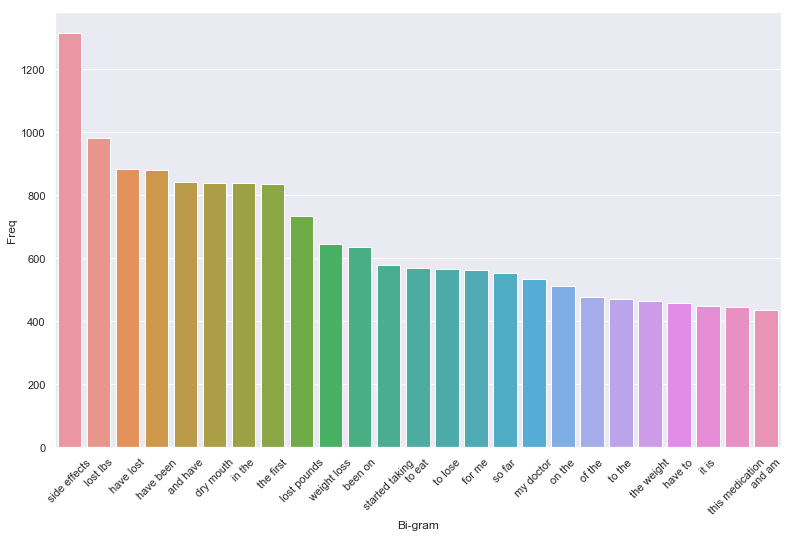

In [30]:
#Most frequently occuring Bi-grams
clean_text_positive= weight_loss_postive['clean_text']

def get_top_n2_words(clean_text_positive, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),
            max_features=2000).fit(clean_text_positive)
    bag_of_words = vec1.transform(clean_text_positive)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(clean_text_positive, n=25)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45);

In [31]:
#Most frequently occuring Bi-grams
clean_text_positive= weight_loss_postive['clean_text']

def get_top_n2_words(clean_text_positive, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3),   stop_words=stop,
            max_features=2000).fit(clean_text_positive)
    bag_of_words = vec1.transform(clean_text_positive)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(clean_text_positive, n=25)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45);

NameError: name 'stop' is not defined

In [32]:
weight_loss_negative = weight_loss[(weight_loss['rating_class'])== 0]

In [33]:
weight_loss_negative.head()

Empty DataFrame
Columns: [Unnamed: 0, UniqueID, drugName, condition, review, rating, date, usefulCount, review_length, word_count, clean_text, rating_class, rating_class_numeric]
Index: []

In [34]:
#Most frequently occuring Bi-grams
clean_text_negative= weight_loss_negative['clean_text']

def get_top_n2_words(clean_text_negative, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),   stop_words=stop,
            max_features=2000).fit(clean_text_negative)
    bag_of_words = vec1.transform(clean_text_negative)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(clean_text_negative, n=25)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45);

NameError: name 'stop' is not defined

In [ ]:
#Most frequently occuring Bi-grams
clean_text_negative= weight_loss_negative['clean_text']

def get_top_n2_words(clean_text_negative, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3),   stop_words=stop,
            max_features=2000).fit(clean_text_negative)
    bag_of_words = vec1.transform(clean_text_negative)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(clean_text_negative, n=25)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)

#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45);

In [49]:
weight_loss['rating_class'].value_counts()

positive    3870
negative     666
neutral      321
Name: rating_class, dtype: int64

In [50]:
tfidf= TfidfVectorizer(ngram_range = (3,4), min_df = 10,sublinear_tf=True)
X =tfidf.fit_transform(weight_loss['clean_text'])
y=weight_loss['rating_class']


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 42)

In [52]:
print(X.shape)
print(y.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4857, 3570)
(4857,)
(3399, 3570)
(1458, 3570)
(3399,)
(1458,)


In [53]:
method = SMOTE()

# Create the resampled feature set
X_resampled, y_resampled = method.fit_sample(X, y)

In [54]:
# Print the value_counts on the original labels y
print(pd.value_counts(pd.Series(y)))

# Print the value_counts
print(pd.value_counts(pd.Series(y_resampled)))

# Run compare_plot
# compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

positive    3870
negative     666
neutral      321
Name: rating_class, dtype: int64
positive    3870
neutral     3870
negative    3870
dtype: int64


In [55]:
mnb = MultinomialNB(alpha = 0.001)
mnb.fit(X_train,y_train)

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [56]:
alphas = np.arange(0.001,1, step=0.1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    mnb = MultinomialNB(alpha=alpha)
    # Fit to the training data
    mnb.fit(X_train, y_train)
    # Predict the labels: pred
    pred = mnb.predict(X_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.001
Score:  0.8834019204389575

Alpha:  0.101
Score:  0.8710562414266118

Alpha:  0.201
Score:  0.8641975308641975

Alpha:  0.30100000000000005
Score:  0.8539094650205762

Alpha:  0.401
Score:  0.8518518518518519

Alpha:  0.501
Score:  0.8491083676268861

Alpha:  0.6010000000000001
Score:  0.8484224965706447

Alpha:  0.7010000000000001
Score:  0.845679012345679

Alpha:  0.801
Score:  0.8401920438957476

Alpha:  0.901
Score:  0.8353909465020576



In [57]:
mnb_predictions = mnb.predict(X_test)
print(confusion_matrix(y_test,mnb_predictions))
print('\n', 'Classification report')
print(classification_report(y_test,mnb_predictions))
# Print the overall accuracy
print('\n', 'accuracy Score')
print(metrics.accuracy_score(y_test,mnb_predictions))


print('\n', 'f1 Score')
print(metrics.f1_score(y_test, mnb_predictions, average='weighted'))

[[ 111    2   89]
 [   6   27   67]
 [   2    4 1150]]

 Classification report
              precision    recall  f1-score   support

    negative       0.93      0.55      0.69       202
     neutral       0.82      0.27      0.41       100
    positive       0.88      0.99      0.93      1156

   micro avg       0.88      0.88      0.88      1458
   macro avg       0.88      0.60      0.68      1458
weighted avg       0.88      0.88      0.86      1458


 accuracy Score
0.8834019204389575

 f1 Score
0.8643603913059348


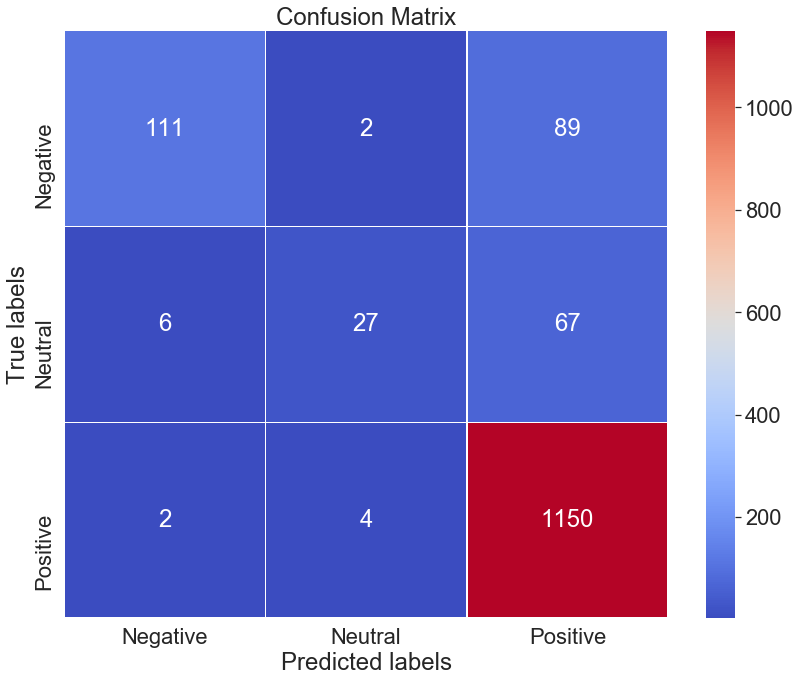

In [58]:
sns.set(rc={'figure.figsize':(12,10)}, font_scale=2)
ax= plt.subplot()
cm = confusion_matrix(y_test, mnb_predictions)
sns.heatmap(cm, annot=True, ax = ax, fmt='g', linewidths=.5, cmap='coolwarm'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative',  'Neutral', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
plt.tight_layout()
plt.savefig('confusion matrix weightloss.png')
plt.show();

In [59]:
probabilities_mnb = mnb.predict_proba(X_test)
y = label_binarize(y, classes=[0,1,2])
n_classes = y.shape[1]
y_dummies=pd.get_dummies(y_test)

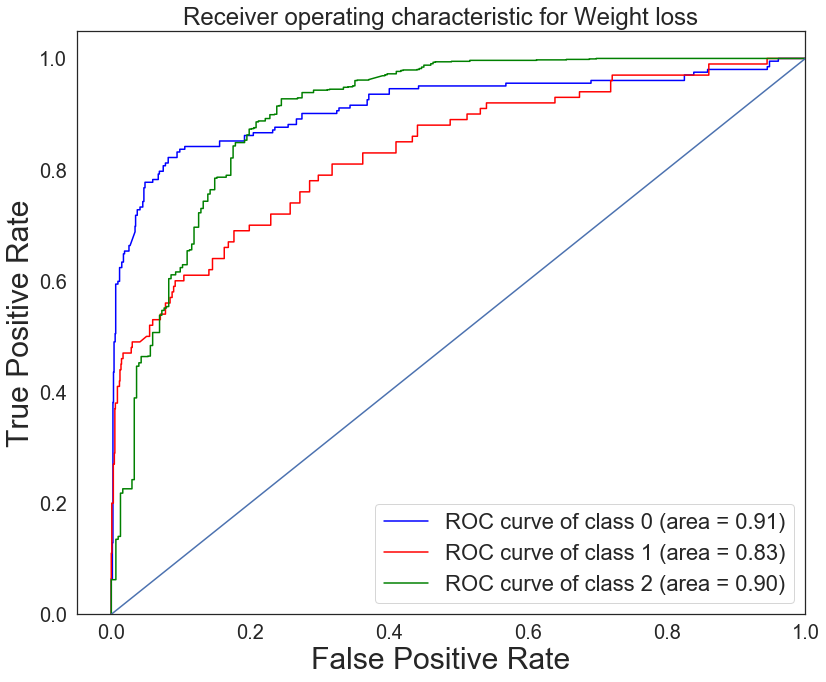

In [60]:
sns.set_style("white")
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_dummies.iloc[:, i], probabilities_mnb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1])
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('False Positive Rate', fontsize = 30)
plt.ylabel('True Positive Rate',fontsize = 30)
plt.title('Receiver operating characteristic for Weight loss')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('ROC weight loss.png')
plt.show();

In [61]:
class_labels = mnb.classes_
print(class_labels)

['negative' 'neutral' 'positive']


In [62]:

def important_features(vectorizer,clf,n):
  
    
    class_labels = clf.classes_
    feature_names =vectorizer.get_feature_names()
    topn_class1 = pd.DataFrame(sorted(zip(mnb.feature_count_[2], feature_names),reverse=True)[:n],columns = ['Freq', 'Feature Name'])
    topn_class2 = pd.DataFrame(sorted(zip(mnb.feature_count_[1], feature_names),reverse=True)[:n],columns = ['Freq', 'Feature Name'])
    topn_class3 = pd.DataFrame(sorted(zip(mnb.feature_count_[0], feature_names),reverse=True)[:n],columns = ['Freq', 'Feature Name'])

        
    return topn_class1, topn_class2, topn_class3

In [63]:
topn_class1, topn_class2, topn_class3 =important_features(tfidf,mnb,25)
positive_rating = topn_class1[['Feature Name', 'Freq']]
neutral_rating=topn_class2[['Feature Name', 'Freq']]
negative_rating=topn_class3[['Feature Name', 'Freq']]


In [64]:
capsule = np.array(Image.open("Download-Capsule-PNG-Images.png"))

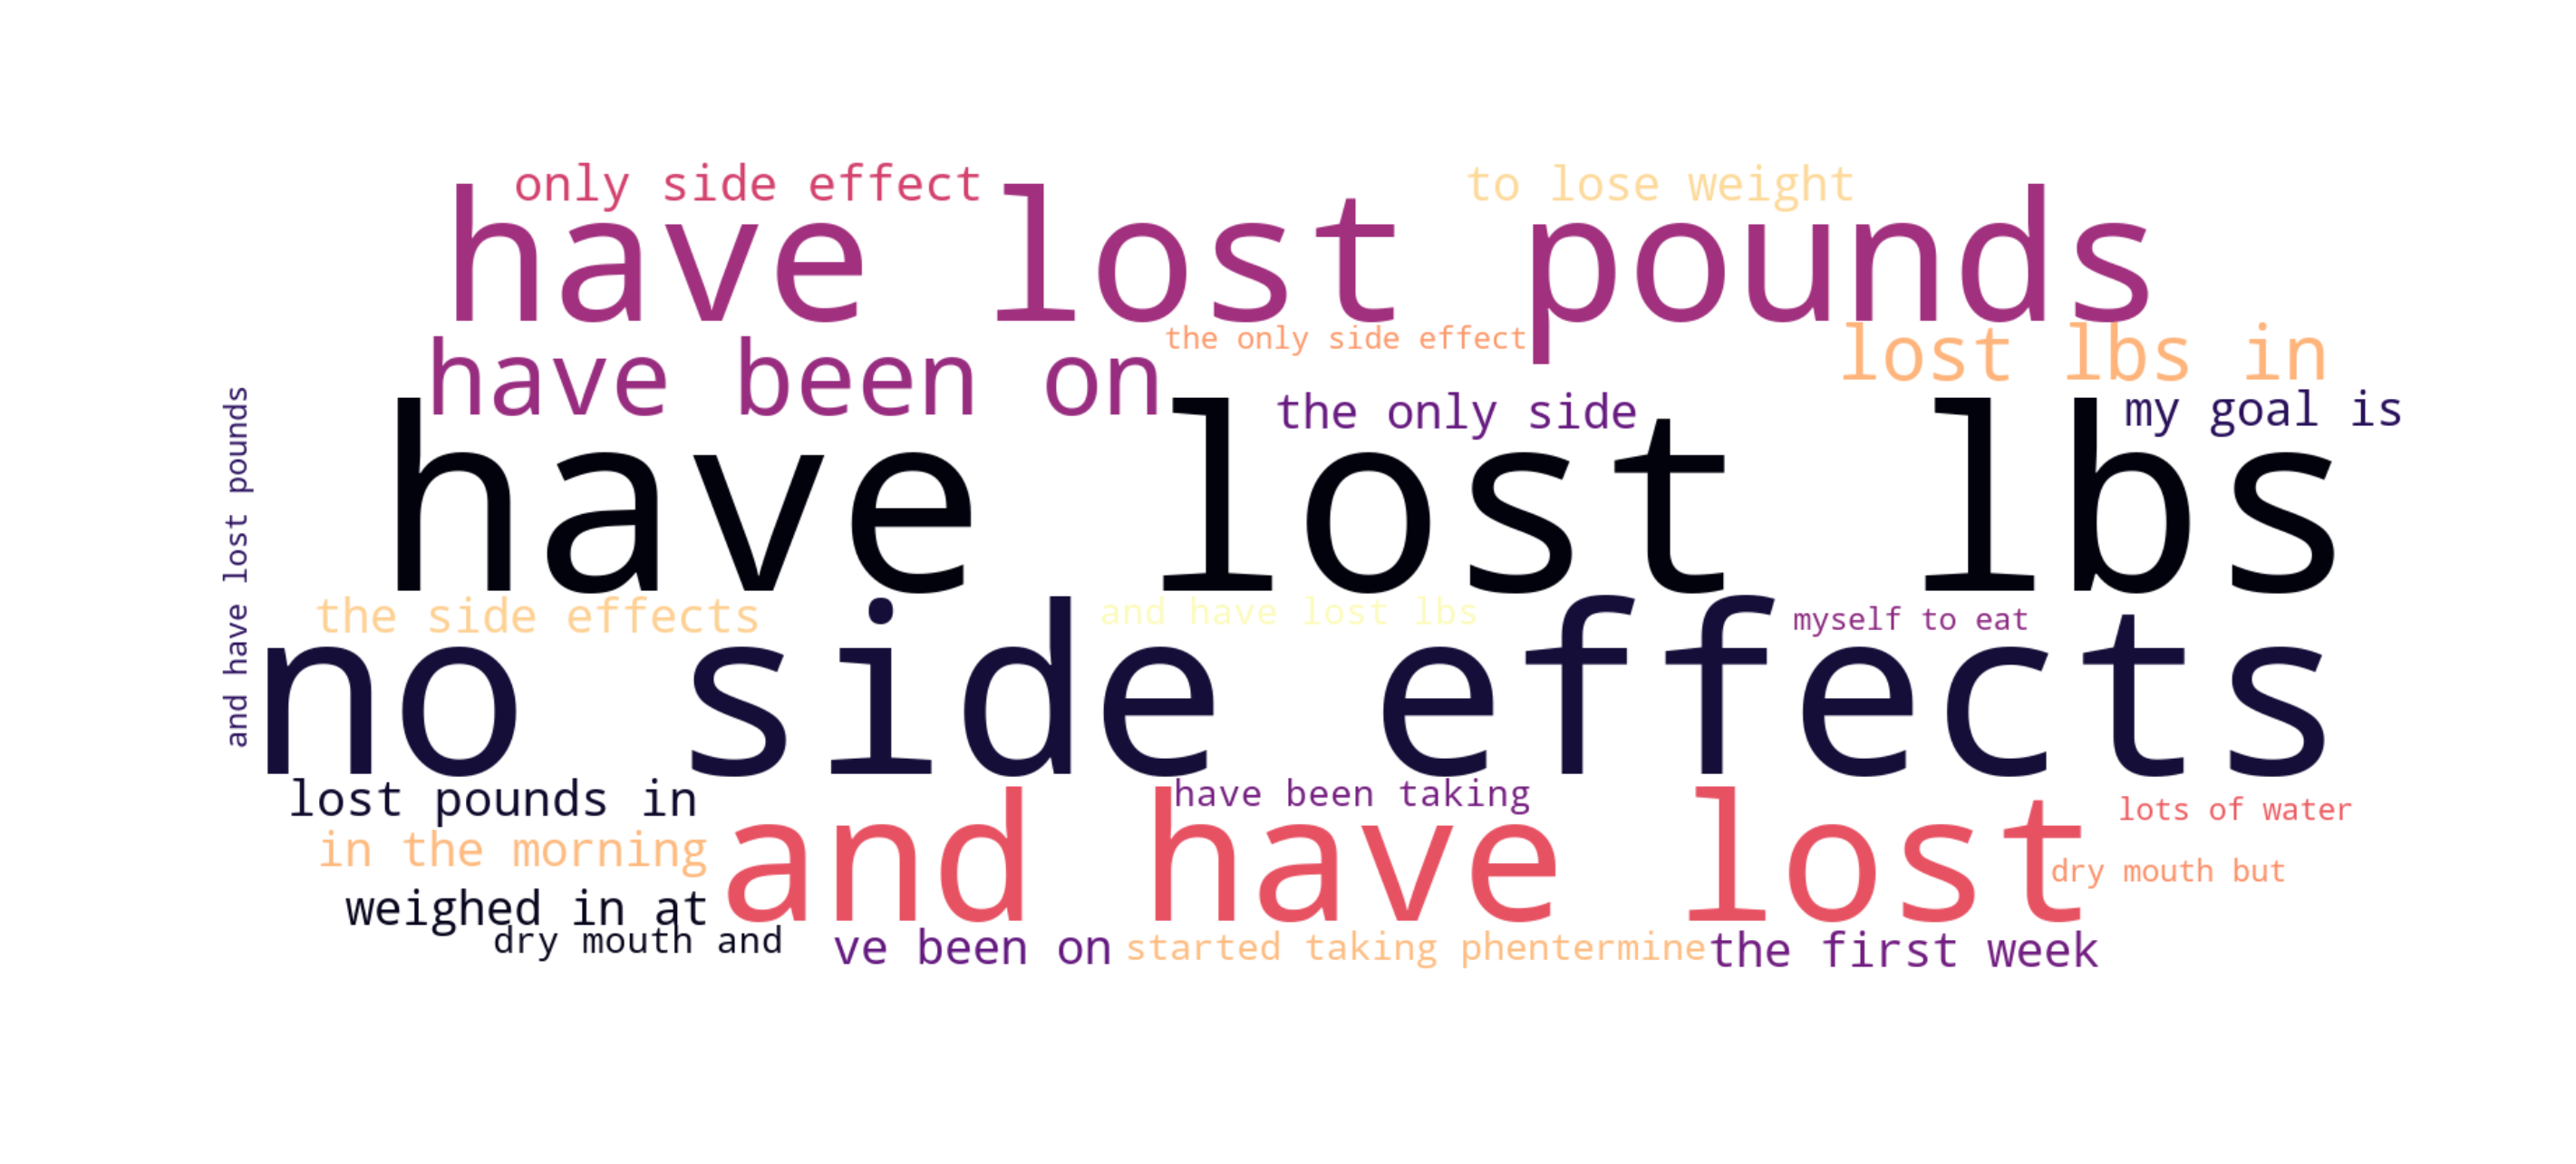

In [65]:
positive = {}
for w, x in positive_rating.values:
    positive[w] = x
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white', mask = capsule,colormap=plt.cm.magma, collocations=False, random_state = 20)
wordcloud.generate_from_frequencies(positive)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.savefig('postive word cloud weight loss.png')
plt.show()

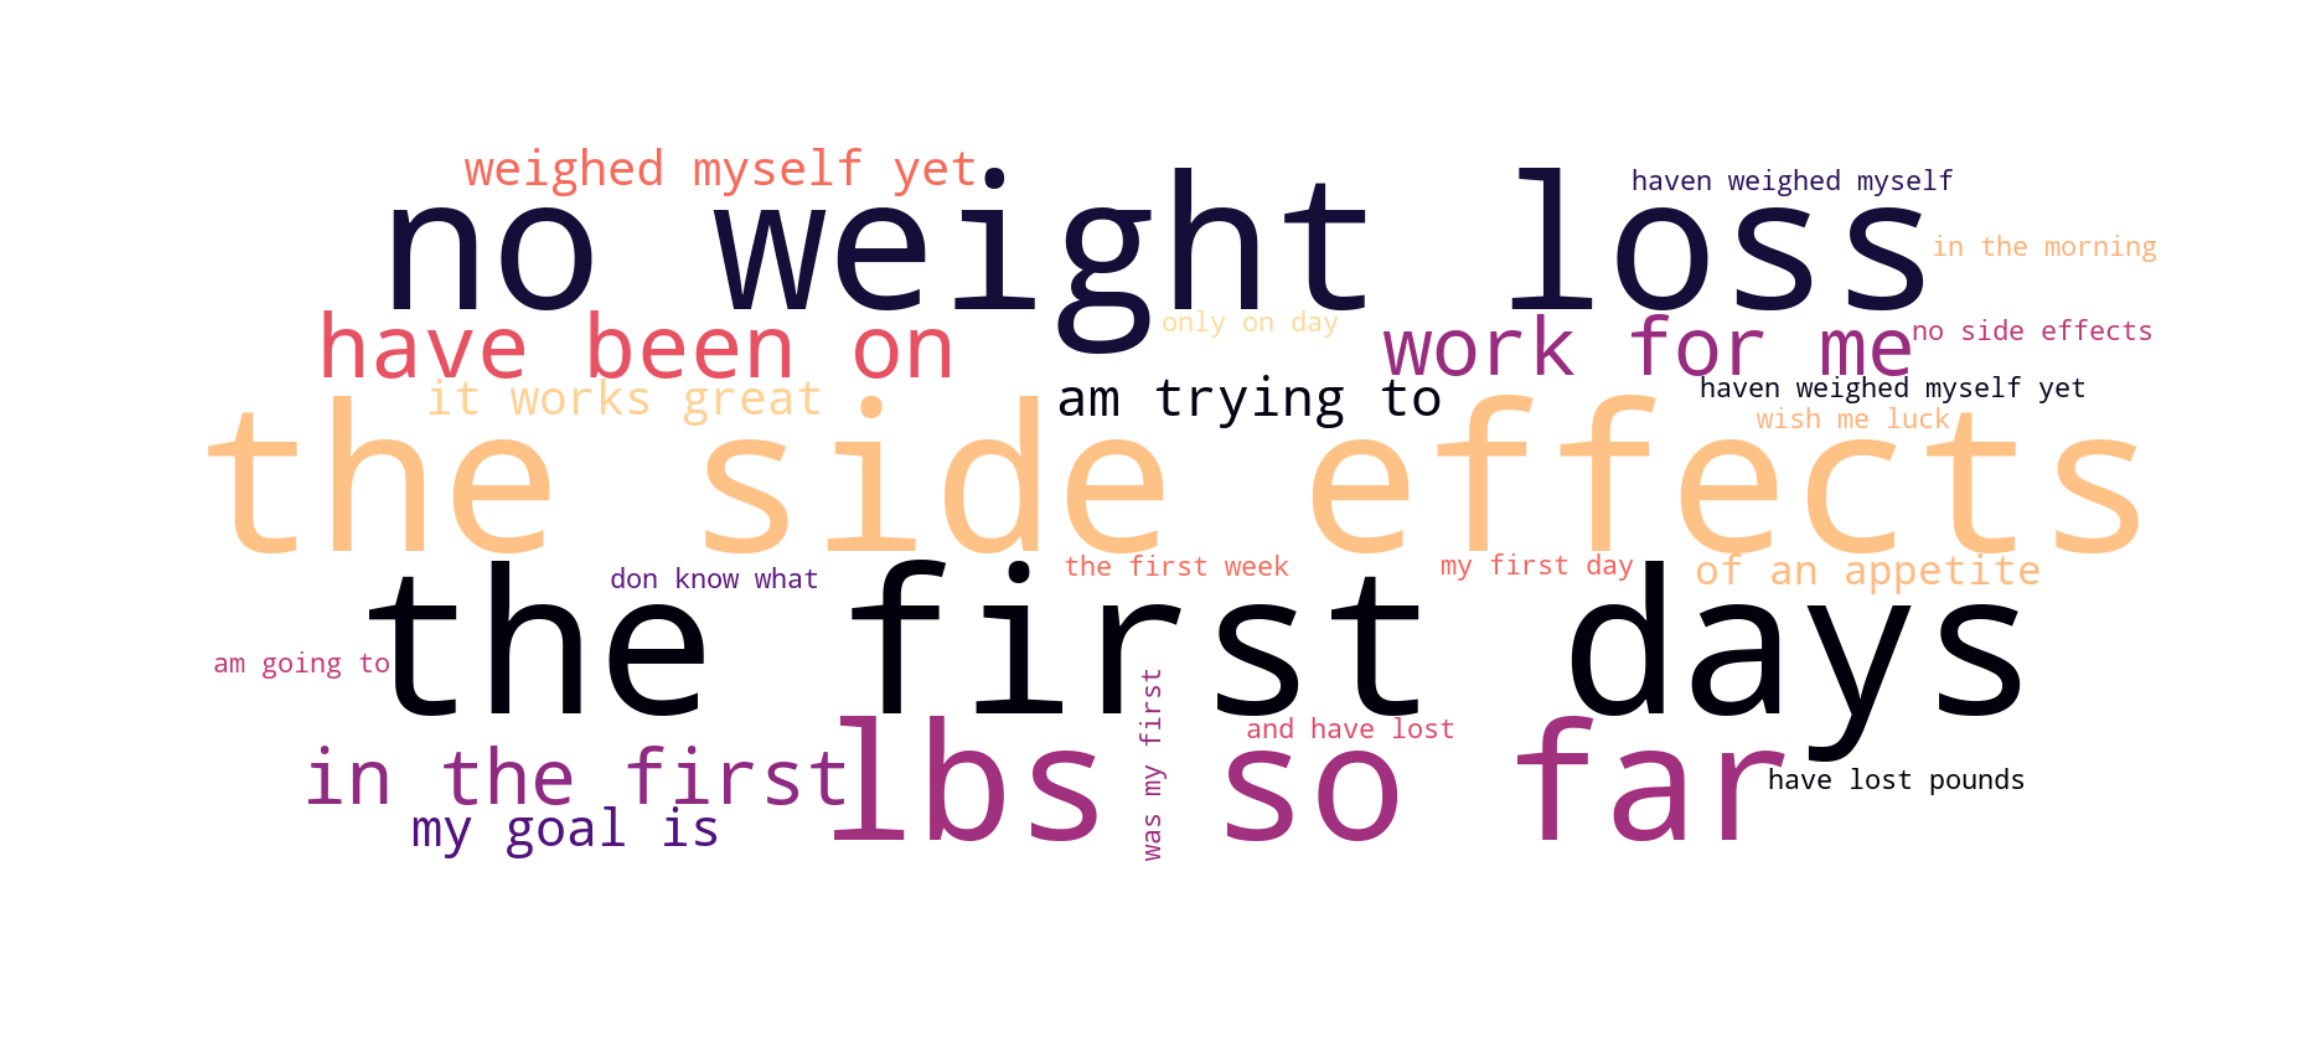

In [66]:
neutral = {}
for w, x in neutral_rating.values:
    neutral[w] = x
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white',mask = capsule, colormap=plt.cm.magma, collocations=False, random_state = 20)
wordcloud.generate_from_frequencies(neutral)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

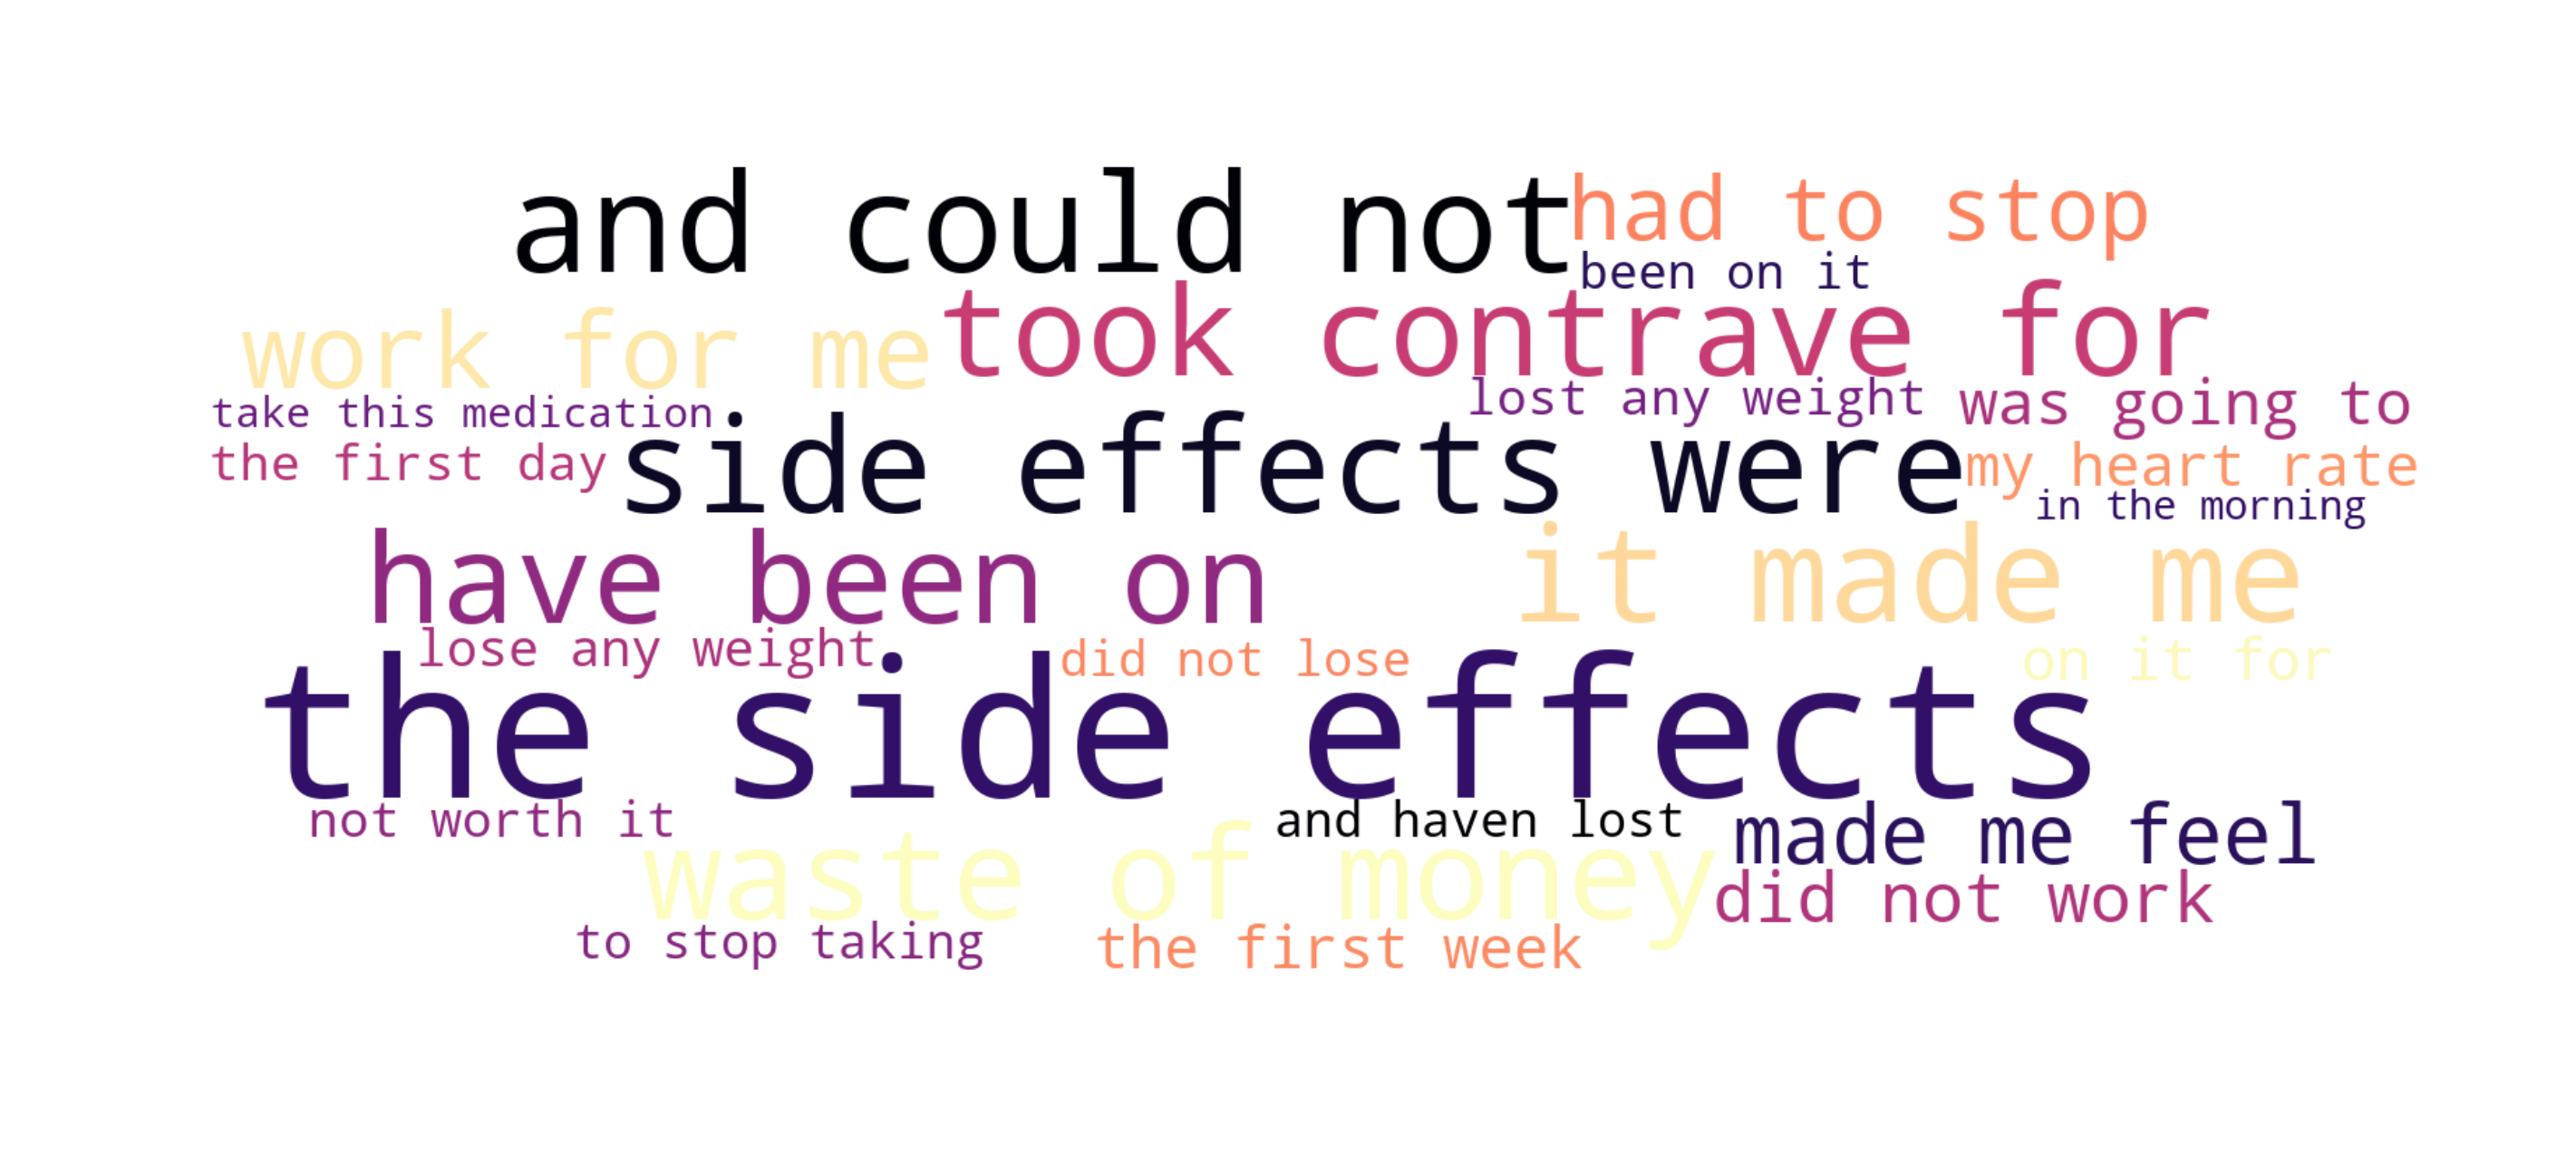

In [67]:
negative = {}
for w, x in negative_rating.values:
    negative[w] = x
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white',mask = capsule,colormap=plt.cm.magma, collocations=False, random_state = 21)
wordcloud.generate_from_frequencies(negative)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.savefig('negative word cloud weight loss.png')
plt.show()

In [68]:
#Obesity['rating_class'].value_counts()

In [69]:
# tfidf= TfidfVectorizer(ngram_range = (1,3), min_df = 5)
# X =tfidf.fit_transform(Obesity['clean_text'])
# y=Obesity['rating_class']

In [70]:
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 42)

In [71]:
# method = SMOTE(kind='regular')

# # Create the resampled feature set
# X_resampled, y_resampled = method.fit_sample(X_obesity, y_obesity)

In [72]:
# # Print the value_counts on the original labels y
# print(pd.value_counts(pd.Series(y)))

# # Print the value_counts
# print(pd.value_counts(pd.Series(y_resampled)))

# # Run compare_plot
# # compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

In [73]:
# model_obesity = LogisticRegression()
# model_obesity.fit(X_train,y_train)
# predictions = model_obesity.predict(X_test)
# print(confusion_matrix(y_test,predictions))
# print('\n', 'Classification report')
# print(classification_report(y_test,predictions))
# # # Print the overall accuracy
# print('\n', 'accuracy Score')
# print(metrics.accuracy_score(y_test,predictions))

In [74]:
Depression = drugs_model[drugs_model['condition'] == 'Depression']

In [75]:
Depression.isnull().sum()

Unnamed: 0              0
UniqueID                0
drugName                0
condition               0
review                  0
rating                  0
date                    0
usefulCount             0
review_length           0
word_count              0
clean_text              0
rating_class            0
rating_class_numeric    0
dtype: int64

In [76]:
tfidf= TfidfVectorizer(ngram_range = (3,4), min_df = 10,sublinear_tf=True)
X =tfidf.fit_transform(Depression['clean_text'])
y=Depression['rating_class']

In [77]:
Depression_train, Depression_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 42)

In [78]:
print(X.shape)
print(y.shape)
print(Depression_train.shape)
print(Depression_test.shape)
print(y_train.shape)
print(y_test.shape)

(12164, 10993)
(12164,)
(8514, 10993)
(3650, 10993)
(8514,)
(3650,)


In [79]:
method = SMOTE()

# Create the resampled feature set
X_resampled, y_resampled = method.fit_sample(X, y)

In [80]:
# Print the value_counts on the original labels y
print(pd.value_counts(pd.Series(y)))

# Print the value_counts
print(pd.value_counts(pd.Series(y_resampled)))

# Run compare_plot
# compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

positive    8348
negative    2700
neutral     1116
Name: rating_class, dtype: int64
positive    8348
neutral     8348
negative    8348
dtype: int64


In [81]:
mnb_dep = MultinomialNB(alpha = 0.001)
mnb_dep.fit(Depression_train,y_train)

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [82]:
alphas = np.arange(0.001,1, step=0.1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    mnb_dep = MultinomialNB(alpha=alpha)
    # Fit to the training data
    mnb_dep.fit(Depression_train, y_train)
    # Predict the labels: pred
    pred = mnb_dep.predict(Depression_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.001
Score:  0.8391780821917808

Alpha:  0.101
Score:  0.8263013698630137

Alpha:  0.201
Score:  0.8186301369863014

Alpha:  0.30100000000000005
Score:  0.810958904109589

Alpha:  0.401
Score:  0.807945205479452

Alpha:  0.501
Score:  0.8024657534246575

Alpha:  0.6010000000000001
Score:  0.7964383561643835

Alpha:  0.7010000000000001
Score:  0.795068493150685

Alpha:  0.801
Score:  0.7893150684931507

Alpha:  0.901
Score:  0.7852054794520548



In [83]:
mnb_predictions_dep = mnb_dep.predict(Depression_test)
print(confusion_matrix(y_test,mnb_predictions_dep))
print('\n', 'Classification report')
print(classification_report(y_test,mnb_predictions_dep))
# Print the overall accuracy
print('\n', 'accuracy Score')
print(metrics.accuracy_score(y_test,mnb_predictions_dep))

[[ 465    9  325]
 [  14  134  182]
 [  55    2 2464]]

 Classification report
              precision    recall  f1-score   support

    negative       0.87      0.58      0.70       799
     neutral       0.92      0.41      0.56       330
    positive       0.83      0.98      0.90      2521

   micro avg       0.84      0.84      0.84      3650
   macro avg       0.87      0.66      0.72      3650
weighted avg       0.85      0.84      0.82      3650


 accuracy Score
0.8391780821917808


In [84]:
probabilities_mnb_dep = mnb_dep.predict_proba(Depression_test)
y = label_binarize(y, classes=[0,1,2])
n_classes = y.shape[1]
y_dummies=pd.get_dummies(y_test)

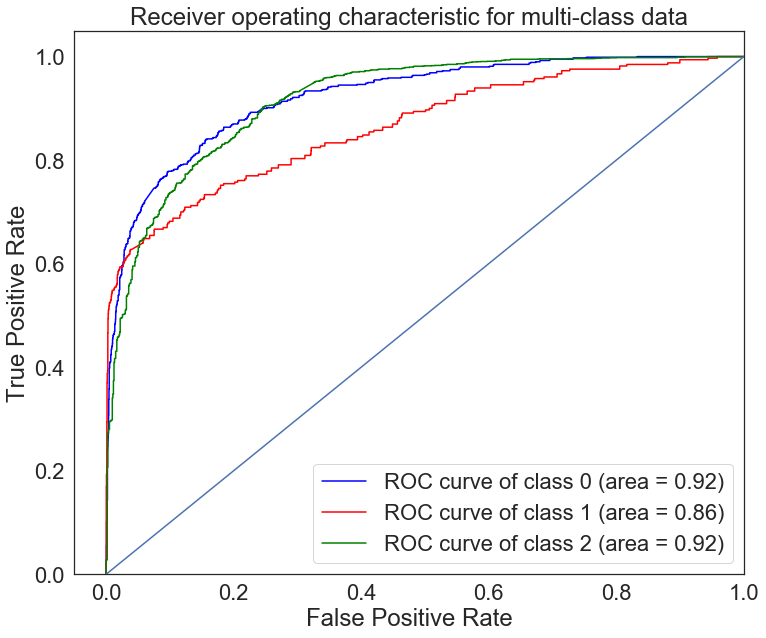

In [85]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_dummies.iloc[:, i], probabilities_mnb_dep[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1])
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right");

In [86]:
topn_class1, topn_class2, topn_class3 =important_features(tfidf,mnb_dep,25)
positive_rating = topn_class1[['Feature Name', 'Freq']]
neutral_rating=topn_class2[['Feature Name', 'Freq']]
negative_rating=topn_class3[['Feature Name', 'Freq']]

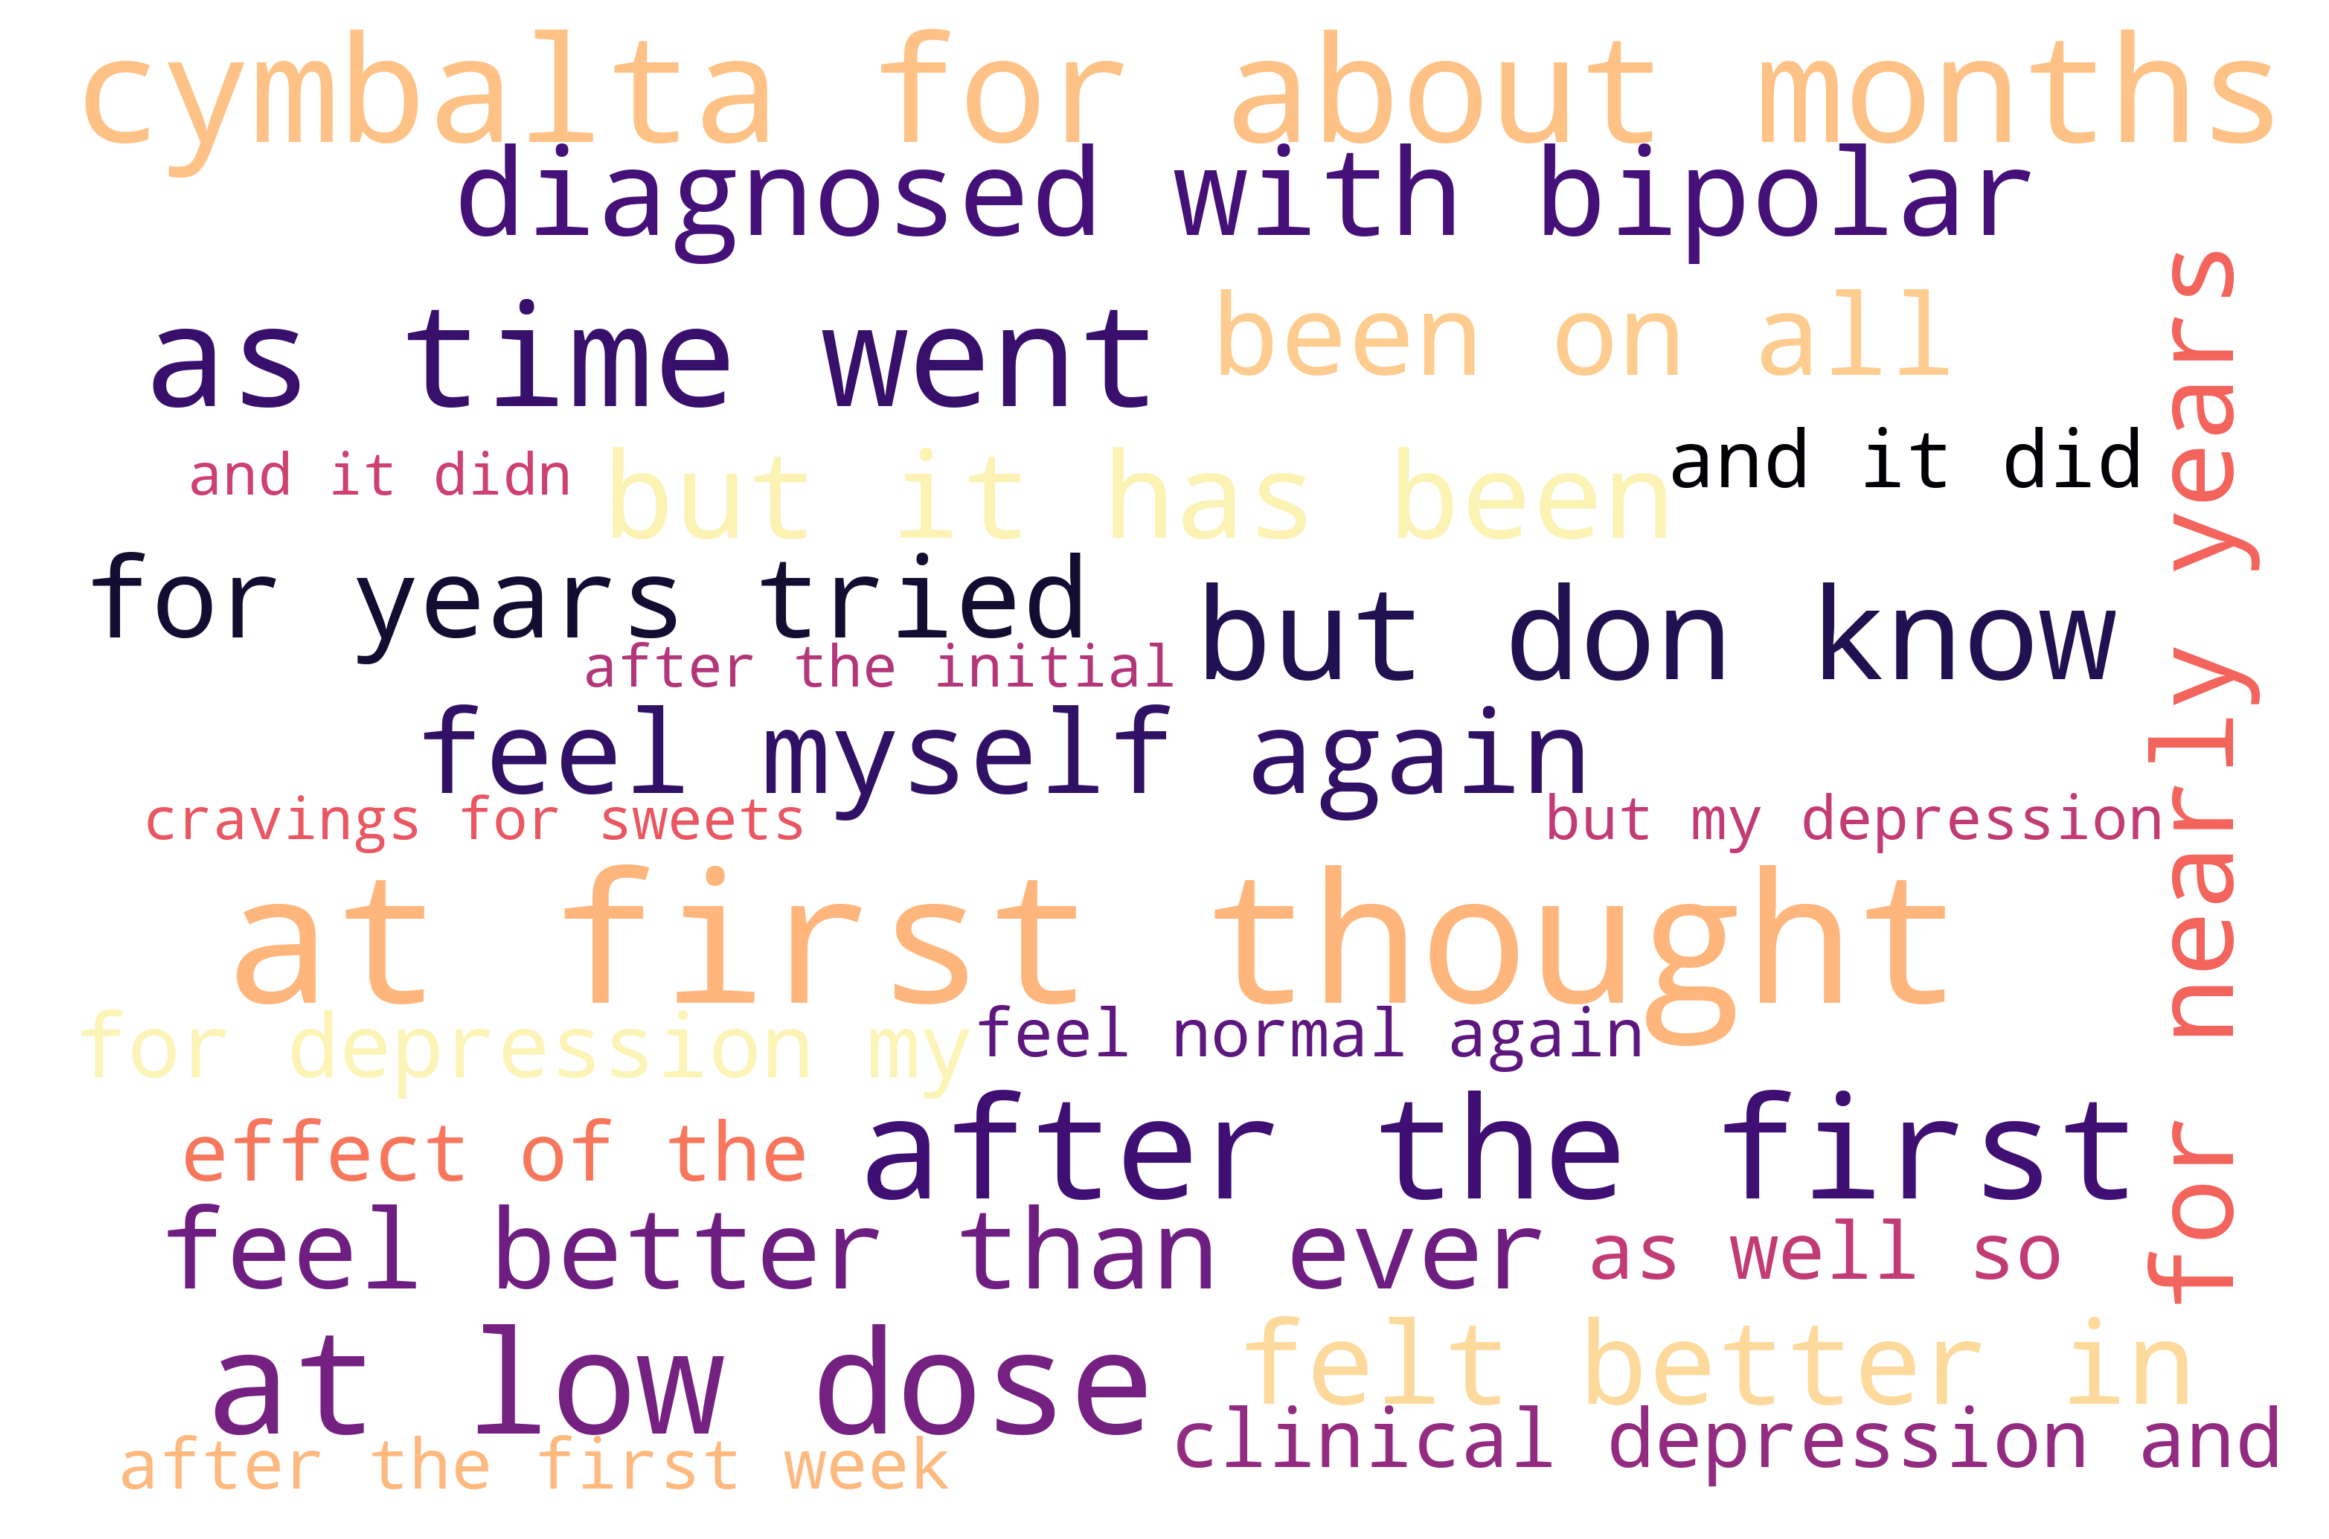

In [87]:
positive = {}
for w, x in positive_rating.values:
    positive[w] = x
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white',colormap=plt.cm.magma, collocations=False)
wordcloud.generate_from_frequencies(positive)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

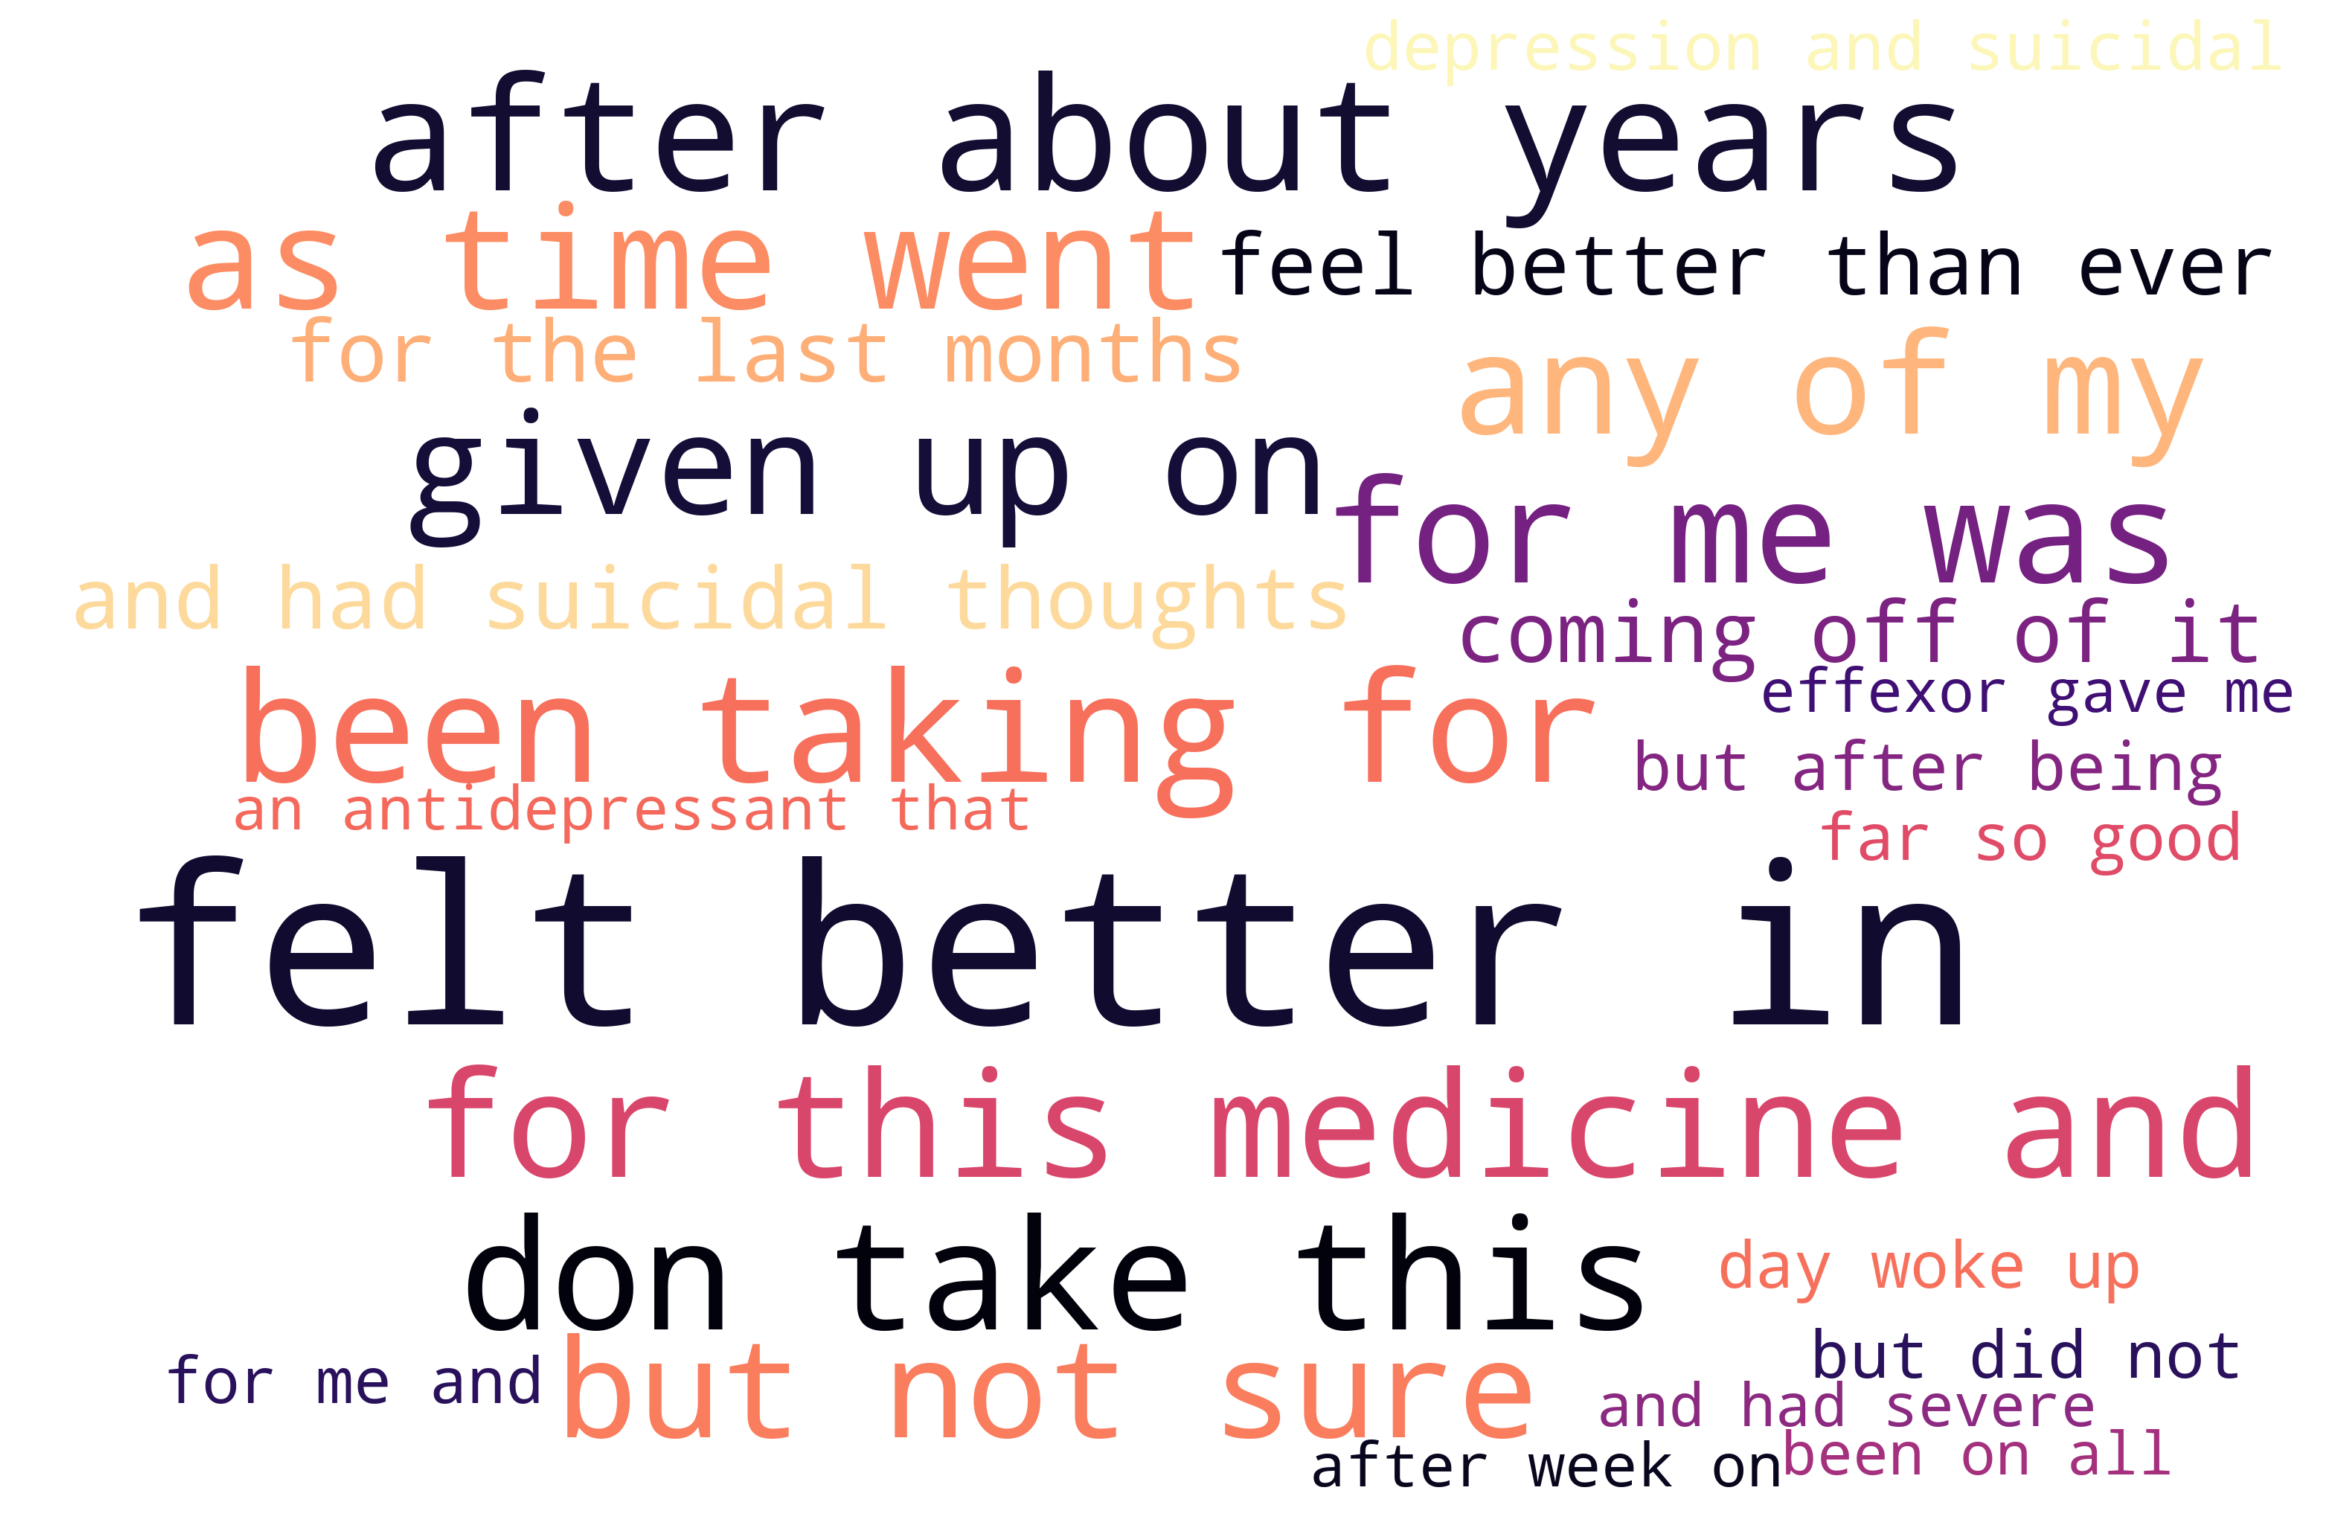

In [88]:
negative = {}
for w, x in negative_rating.values:
    negative[w] = x
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white',colormap=plt.cm.magma, collocations=False, random_state = 42)
wordcloud.generate_from_frequencies(negative)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()